In [251]:
# Initialize Otter
import otter
grader = otter.Notebook("Traffic.ipynb")

# Final Project: Traffic
## Due Date: Monday, December 13th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions within your own groups**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.

# Data 100 Final Project: Traffic in a post-lockdown world

**Scenario:** You're a data scientist at Uber -- sitting in a war room on March 16, 2020, 1 day after California-wide COVID lockdown measures began and the day shelter-in-place measures are announced in the bay area. The entire data science department is on fire: All of your existing traffic models have regressed *significantly*. Given the sudden change in traffic patterns (i.e., no traffic at all), the company's traffic estimates are wildly incorrect. This is a top priority for the company. Since traffic estimates are used directly for pricing strategies, this is actively costing the company millions every hour. You are tasked with fixing these models.

**Takeaways:** How do you "fix" models that have learned biases from pre-lockdown traffic? How do you train new ones, with just 24 hours of data? What sorts of data do you examine, to better understand the situation? In the midst of company-wide panic, you'll need a strong inferential acumen to lead a robust data science response. In this project, we'll walk you through a simulated war room data science effort, culminating in some strategies to fix models online, which are experiencing large distributional shifts in data.

For this project, we'll explore traffic data provided by the **Uber Movement** dataset, specifically around the start of COVID shutdowns in March 2020. Your project is structured around the following ideas:

```
1. Guided data cleaning: Clustering data spatially
    a. Load Uber traffic speeds dataset
    b. Map traffic speeds to Google Plus Codes (spatially uniform)
        i. Load node-to-gps-coordinates data
        ii. Map traffic speed to GPS coordinates
        iii. Convert GPS coordinates to plus code regions
        iv. Sanity check number of plus code regions in San Francisco
        v. Plot a histogram of the standard deviation in speed, per plus code region.
    c. Map traffic speeds to census tracts (spatially non-uniform)
        i. Download census tracts geojson
        ii. Map traffic speed to census tracts
        iii. Sanity check number of census tracts in San Francisco with data.
        iv. Plot a histogram of the standard deviation in speed, per census tract.
    d. What defines a "good" or "bad" spatial clustering?
2. Guided EDA: Understanding COVID lockdown impact on traffic
    a. How did lockdown affect average traffic speeds?
        i. Sort census tracts by average speed, pre-lockdown.
        ii. Sort census tracts by average speed, post-lockdown.
        iii. Sort census tracts by change in average speed, from pre to post lockdown.
        iv. Quantify the impact of lockdown on average speeds.
        v. Quantify the impact of pre-lockdown average speed on change in speed.
    b. What traffic areas were impacted by lockdown?
        i. Visualize heatmap of average traffic speed per census tract, pre-lockdown.
        ii. Visualize change in average daily speeds pre vs. post lockdown.
        iii. Quantify the impact of lockdown on daily speeds, spatially.
3. Open-Ended EDA: Understanding lockdown impact on traffic times
    a. Download Uber Movement (Travel Times) dataset
4. Guided Modeling: Predict traffic speed post-lockdown
    a. Predict daily traffic speed on pre-lockdown data
        i. Assemble dataset to predict daily traffic speed.
        ii. Train and evaluate linear model on pre-lockdown data.
    b. Understand failures on post-lockdown data
        i. Evaluate on post-lockdown data
        ii. Report model performance temporally
    c. "Fix" model on post-lockdown data
        i. Learn delta off of a moving bias
        ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?
        iii. Naively retrain model with post-lockdown data
        iv. What if you just ignore the change point?
5. Open-Ended Modeling: Predicting travel times post-lockdown
```

Concepts tested: regex, pivot, join, grouping, inferential thinking

In [252]:
import pandas as pd
import geopandas as gpd
import numpy as np
import csv
import json
import os
import contextily as cx
from collections import defaultdict
import re
from typing import Callable
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import math

from zipfile import ZipFile
zf = ZipFile('data.zip', 'r')
zf.extractall('.')

# more readable exceptions
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.
The iwut extension is already loaded. To reload it, use:
  %reload_ext iwut


# Step 1 - Guided Data Cleaning: Partitioning Data Spatially

Our hope is answer: How do we group information spatially? We'll specifically look at 2 ways of partitioning data spatially, to understand the impact of spatial partitioning strategies on our analyses:

1. Dividing the world uniformly into slices, like Google's plus codes.
2. Dividing the world according to population, using census tracts.

In this step, we'll load the following datasets that we'll need for this project:

- Daily travel times from Uber Movement data in March 2020 from San Francisco, by census tract
- Daily traffic speeds from Uber Movement data in Q1 2020 from San Francisco, between OSM nodes
- Census tracts dividing San Francisco by GPS coordinates
- Mapping from OSM nodes to GPS coordinates

There are several terms and concepts to get familiar with upfront:

- **Open Street Maps (OSM)** provides nodes (points in space, [wiki](https://wiki.openstreetmap.org/wiki/Node)) and ways (segments between nodes [wiki](https://wiki.openstreetmap.org/wiki/Way)). These IDs are used in the Uber Movement dataset to identify streets in the traffic speeds dataset.
- **Census Tracts** provided by the county of San Francisco geographically divides space according to the US 2010 Census. This is used in the Uber Movement dataset to identify regions of differing travel times.

## 1.a. Load Uber traffic speeds dataset

The dataset is located at `data/movement-speeds-daily-san-francisco-2020-3.csv`. **Load this dataset into a dataframe.**

*The original dataset from Uber was provided hourly and took up 2.1 GB on disk, which means it couldn't fit into your 1GB of RAM. You can find the dataset preparation script at `data/PrepareTrafficDataset.ipynb` which aggregated within each day, reducing the dataset to just 55MB on disk.*

*This was originally going to be question in this project, but it takes 22 minutes to run. Better yet, if you mess up, your kernel dies and you start over. We deemed it too frustrating and preprocessed the dataset to spare you the pain... but just know that this is a real-world issue!*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [253]:
# Load Uber Movement (Movement Speeds) dataset into dataframe
speeds_to_nodes = pd.read_csv("data/movement-speeds-daily-san-francisco-2020-3.csv")

speeds_to_nodes

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean
0,281266,702258940,1,59.674042
1,281266,702274215,1,68.444042
2,302876,240259516,1,66.446500
3,302878,437325360,1,65.516850
4,302883,65381191,1,61.880556
...,...,...,...,...
1586647,6569140748,1350115374,31,68.484833
1586648,6570476556,4551993266,31,36.837000
1586649,6573249373,4911384010,31,39.021000
1586650,6573553681,256888796,31,68.728333


In [254]:
grader.check("q1a")

q1a results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.b. Map traffic speed to Google Plus Codes

Google Plus Codes divide up the world uniformly into rectangular slices ([link](https://maps.google.com/pluscodes/)). Let's use this to segment traffic speeds spatially. Take a moment to answer: **Is this spatial structure effective for summarizing traffic speed?** Before completing this section, substantiate your answer with examples of your expectations (e.g., we expect A to be separated from B). After completing this section, substantiate your answer with observations you've made.

<!--
BEGIN QUESTION
name: q1b
points: 2
manual: True
-->

Yes because rectangular areas usually have the same traffic speeds so if we segment many of those rectangular areas we should be able to segment traffic speeds in an effective manner. I would expect school zone to be separated from highway zone because they have different traffic speeds and we can draw usually a big zone around the area with the specific speed limits.

<!-- END QUESTION -->



### 1.b.i. Load Node-to-GPS-Coordinate Data

In this substep, we'll load a mapping from OSM nodes to GPS coordinates. The dataset is provided in a gzip'ed XML file from OpenStreetMaps (OSM). The mapping from OSM nodes to GPS coordinates was downloaded from https://download.bbbike.org/osm/bbbike/SanFrancisco/SanFrancisco.osm.gz. We've downloaded this for you, to avoid any issues with OSM updates.

**If** you try to load the provided `.osm` (an `.xml` in disguise) using Python's built-in XML utilities **(by uncommenting the last 2 lines in the below cell)**, you will hit an out-of-memory error, as your kernel is forced to restart.

In [255]:
# [OSM] - Read the OSM XML and extract mapping from node ID to GPS coordinates
PATH_OSM = os.path.expanduser('data/SanFrancisco.osm')

# Runs out of memory! File itself is 430 MB, even when filtering out
# irrelevant rows, and remaining 3M rows are too expensive to parse,
# resulting in OOM

# import xml.etree.ElementTree as ET
# _tree = ET.parse(PATH_OSM)

Your above code hits a memory error, so instead, we will use our handy-dandy tool--regex--from earlier in the semester to load just the parts of the file that we need. **Given the XML snippet below, write a regex pattern to extract OSM node ID, latitude, and longitude.** (The first capture group should be node ID. The second should be latitude, and the third should be longitude.) A snippet of the XML is included below ([screenshot](https://extract.bbbike.org/extract-screenshots.html)):

```
<?xml version='1.0' encoding='UTF-8'?>
<osm version="0.6" generator="osmconvert 0.8.3">
    <bounds minlat="42.4543" minlon="-2.4761999" maxlat="42.4..."/>
    <node id="26861066" lat="42.471111" lon="-2.454722" version="..."/>
        <tag k="name" v="Camping La Playa"/>
        <tag k="tourism" v="camp_site"/>
        <tag k="operator" v="private"/>
        ...
    </node>
    <node id="34793287" lat="42.4713587" lon="-2.4510783" version="..."/>
        <tag k="created_by" v="JOSM"/>
    </node>
    <node id="34793294" lat="42.4610836" lon="-2.4303622" version="..."/>
    <node id="34793297" lat="42.4548363" lon="-2.4287657" version="..."/>
    ...
</osm>
```

In [256]:
# [OSM] - Read the OSM XML using a regex operation instead.
def read_node_lat_lon(path: str, pattern: str, line_condition: Callable):
    """
    Read the provided path line at a line. If the provided regex pattern
    has a match, return the grouped matches as items in a generator.
    
    :param path: Path to read data from
    :param pattern: Regex pattern to test against each line
    :param line_condition: function that returns if we should check regex
        against current line
    """
    with open(path) as f:
        for line in f:
            result = re.search(pattern, line)
            if result is not None and line_condition(result):
                yield int(result.group(1)), float(result.group(2)), float(result.group(3))

In [257]:
node_ids = set(speeds_to_nodes.osm_start_node_id) | set(speeds_to_nodes.osm_end_node_id)

NODE_PATTERN =  r"node id=\"(.*)\".*lat=\"(.*)\".*lon=\"(.*)\".*version"

node_to_gps = pd.DataFrame(read_node_lat_lon(
    PATH_OSM,
    pattern=NODE_PATTERN,
    line_condition=lambda result: int(result.group(1)) in node_ids
), columns=['osm_node_id', 'Latitude', 'Longitude'])
node_to_gps

,osm_node_id,Latitude,Longitude
0,26118026,37.675280,-122.389194
1,29891973,37.674935,-122.389130
2,29892598,37.716892,-122.398893
3,30033679,37.599877,-122.376497
4,30033686,37.642167,-122.405946
...,...,...,...
19139,6522255428,37.760543,-122.443563
19140,6522255492,37.759317,-122.444996
19141,6522764204,37.762163,-122.436143
19142,6522764212,37.756061,-122.436761


In [258]:
grader.check("q1bi")

q1bi results: All test cases passed!

### 1.b.ii. Map traffic speed to GPS coordinates.

Traffic speeds are currently connected to OSM nodes. You will then use the mapping from OSM nodes to GPS coordinates, to map traffic speeds to GPS coordinates. **Link each traffic speed measurement to the GPS coordinate of its starting node.**

**Note**: For simplicity, assume each segment is associated with the node it *starts* with. 

**Hint**: Not all nodes are included in the OSM node mapping. Make sure to ignore any nodes without valid GPS coordinates.

<!--
BEGIN QUESTION
name: q1bii
points: 3
-->

In [259]:
# Find mapping from traffic speeds to GPS coordinates
speeds_to_gps = pd.merge(left=speeds_to_nodes, right=node_to_gps, left_on='osm_start_node_id', right_on='osm_node_id')
speeds_to_gps

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude
0,26118026,259458979,1,64.478000,26118026,37.675280,-122.389194
1,26118026,259458979,2,62.868208,26118026,37.675280,-122.389194
2,26118026,259458979,3,62.211750,26118026,37.675280,-122.389194
3,26118026,259458979,4,62.192458,26118026,37.675280,-122.389194
4,26118026,259458979,5,61.913292,26118026,37.675280,-122.389194
...,...,...,...,...,...,...,...
417634,4069109544,615120176,30,38.956000,4069109544,37.732039,-122.507126
417635,5448539901,65446993,16,25.627000,5448539901,37.622476,-122.413763
417636,302964668,4069109544,19,40.802000,302964668,37.732418,-122.507206
417637,302964668,4069109544,20,36.076000,302964668,37.732418,-122.507206


In [260]:
grader.check("q1bii")

q1bii results: All test cases passed!

### 1.b.iii. Convert GPS coordinates to plus code regions.

Plus code regions divide up the world into uniformly-sized rectangles, which we will assume is 0.012 degrees latitudiunally and longitudinally. **For each traffic speed row, compute the plus code region it belongs to**, based on its GPS coordinates.

To do this, we suggest computing a latitudinal index `plus_latitude_idx` and a longitudinal index `plus_longitude_idx` for the plus code region each row belongs to. *Make sure these columns are integer-valued*.

**Hint**: If you're running into nans, you did 1.b.ii. incorrectly!

<!--
BEGIN QUESTION
name: q1biii
points: 3
-->

In [261]:
speeds_to_gps["plus_latitude_idx"] =  speeds_to_gps["Latitude"].apply(lambda x: int(x/0.012)) # do this however you like
speeds_to_gps["plus_longitude_idx"] =  speeds_to_gps["Longitude"].apply(lambda x: int(x/0.012)) 
speeds_to_gps

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx
0,26118026,259458979,1,64.478000,26118026,37.675280,-122.389194,3139,-10199
1,26118026,259458979,2,62.868208,26118026,37.675280,-122.389194,3139,-10199
2,26118026,259458979,3,62.211750,26118026,37.675280,-122.389194,3139,-10199
3,26118026,259458979,4,62.192458,26118026,37.675280,-122.389194,3139,-10199
4,26118026,259458979,5,61.913292,26118026,37.675280,-122.389194,3139,-10199
...,...,...,...,...,...,...,...,...,...
417634,4069109544,615120176,30,38.956000,4069109544,37.732039,-122.507126,3144,-10208
417635,5448539901,65446993,16,25.627000,5448539901,37.622476,-122.413763,3135,-10201
417636,302964668,4069109544,19,40.802000,302964668,37.732418,-122.507206,3144,-10208
417637,302964668,4069109544,20,36.076000,302964668,37.732418,-122.507206,3144,-10208


In [262]:
grader.check("q1biii")

q1biii results: All test cases passed!

### 1.b.iv. Sanity check number of plus code regions in San Francisco.

**Compute the number of unique plus codes found in your dataset**. You're checking that the number isn't ridiculous, like 1, or 100,000 (SF is 231 sq mi, so 100k tracts would average 12 sq ft per tract).

If you followed the suggestion above, this is the number of unique `(plus_latitude_idx, plus_longitude_idx)` pairs.

<!--
BEGIN QUESTION
name: q1biv
points: 4
-->

In [263]:
# You're expecting 276 plus codes here. Don't just type "276" 
# below to pass the autograder. The goal is to sanity check your 
# dataframe!
num_pluscode_regions = (~speeds_to_gps.duplicated(['plus_latitude_idx','plus_longitude_idx'])).sum()
num_pluscode_regions

276

In [264]:
grader.check("q1biv")

q1biv results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.b.v. How well do plus code regions summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "plus code region" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use the statistics above to answer these questions, and compute any additional statistics you need. Additionally explain *why these questions are important to assessing the quality of a spatial clustering*.

**Hint**: Run the autograder first to ensure your variance average and average variance are correct, before starting to draw conclusions.

In the first cell, write your written answers. In the second cell, complete the code.

<!--
BEGIN QUESTION
name: q1bv1
points: 2
manual: True
-->



I think the average variance is reasonable because the plus codes do capture meaningful subpopulations as the average variance is relatively low, which means each cluster has similar rows with similar speed_mph_mean. Differences between subpopulation/variance_average_by_pluscode is greater than differences within a subpopulation/average_variance_by_pluscode as shown 10.13573858675904 > 8.684748294968637 respectively. So it is good that we are separating clusters into different clusters by latitude and longtitude and each clusters have similar speed_mph_mean. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1bv2
points: 2
manual: True
-->

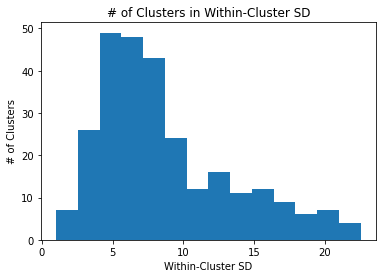

8.684748294968637
10.13573858675904


,speed_mph_mean
0,3.650232
1,20.704487
2,12.342234
3,4.083821
4,21.390912
...,...
271,15.293632
272,17.915911
273,14.243592
274,12.237229


In [265]:
speed_variance_by_pluscode = speeds_to_gps.groupby(['plus_latitude_idx','plus_longitude_idx'],as_index=False).apply(lambda x : x.std())[["speed_mph_mean"]] # compute traffic speed variance in each plus code region

# plot a histogram 
plt.title("# of Clusters in Within-Cluster SD")
plt.ylabel("# of Clusters")
plt.xlabel("Within-Cluster SD")
_ = plt.hist(speed_variance_by_pluscode.to_numpy(), bins='auto') #cluster index y = corresponding sd
plt.show()

average_variance_by_pluscode = speed_variance_by_pluscode.mean()[0]
variance_average_by_pluscode = speeds_to_gps.groupby(['plus_latitude_idx','plus_longitude_idx'],as_index=False).apply(lambda x : x.mean())[["speed_mph_mean"]].std()[0]

print(average_variance_by_pluscode )
print(variance_average_by_pluscode)
speed_variance_by_pluscode

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1bv3
points: 3
-->

In [266]:
speed_variance_by_pluscode

,speed_mph_mean
0,3.650232
1,20.704487
2,12.342234
3,4.083821
4,21.390912
...,...
271,15.293632
272,17.915911
273,14.243592
274,12.237229


In [267]:
grader.check("q1bv3")

q1bv3 results: All test cases passed!

## 1.c. Map traffic speed to census tract.

Census tracts divide the space much less uniformly, subdividing regions that we were interested in into smaller zones. This suggests promise in providing informative spatial segments. Note that the daily traffic speeds are provided between OpenStreetMap (OSM) nodes, so we'll need to map nodes to census tracts somehow.

Above, we've mapped traffic speeds to GPS coordinates. Below, we'll then link GPS coordinates to census tracts, to complete the mapping from traffic speeds to census tracts.

### 1.c.i. Download Census Tracts Geojson

**Load the census tracts geojson.** Make sure to see the relevant [geopandas io documentation](https://geopandas.org/docs/user_guide/io.html) to see how to load a geojson.

**Hint**: It should take you just one line to load.

<!--
BEGIN QUESTION
name: q1ci
points: 1
-->

In [268]:
import geopandas
PATH_TRACTS = os.path.expanduser('data/san_francisco_censustracts.json')
tract_to_gps = geopandas.read_file(PATH_TRACTS)
tract_to_gps['MOVEMENT_ID'] = tract_to_gps['MOVEMENT_ID'].astype(int)
tract_to_gps

,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1,"Sargent Creek, San Ardo","MULTIPOLYGON (((-121.59511 36.11126, -121.5401..."
1,2,"400 Northumberland Avenue, Redwood Oaks, Redwo...","MULTIPOLYGON (((-122.22463 37.46507, -122.2236..."
2,3,"18300 Sutter Boulevard, Morgan Hill","MULTIPOLYGON (((-121.67978 37.15859, -121.6719..."
3,4,"2700 Stoughton Way, Sheffield, Sacramento","MULTIPOLYGON (((-121.35921 38.57175, -121.3462..."
4,5,"3200 Huntsman Drive, Rosemont Park, Sacramento","MULTIPOLYGON (((-121.37512 38.55309, -121.3715..."
...,...,...,...
2705,2706,"10000 Bobbell Drive, Elk Grove","MULTIPOLYGON (((-121.48392 38.40874, -121.4787..."
2706,2707,"400 Ericwood Court, Manteca","MULTIPOLYGON (((-121.22695 37.82647, -121.2185..."
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506..."
2708,2709,"1200 Halyard Drive, West Sacramento","MULTIPOLYGON (((-121.58346 38.57860, -121.5827..."


In [269]:
grader.check("q1ci")

q1ci results: All test cases passed!

### 1.c.ii Map traffic speed to census tracts.

You will need to *spatially join* the (1) mapping from traffic speed to GPS coordinates `speed_to_gps` and (2) the mapping from GPS coordinates to boundaries of census tracts `tract_to_gps` to group all traffic speeds by census tract. This "spatial join" is an advanced feature recently released (as of time of writing, in Oct 2021) in geopandas, which allows us to connect single points to their enclosing polygons. You will do this question in 3 parts:

1. Convert the last dataframe `speeds_to_gps` into a geopandas dataframe `speeds_to_points`, where GPS coordinates are now geopandas points. See this tutorial: https://geopandas.org/gallery/create_geopandas_from_pandas.html#From-longitudes-and-latitudes
2. Set the coordinate-system for the new geopandas dataframe to the "world geodesic system" [link](https://epsg.io/4326), or in other words, the coordinate system that GPS coordinates are reported in.
3. Compute a spatial join between census tracts `tract_to_gps` and the geopandas traffic speeds `speeds_to_points`

<!--
BEGIN QUESTION
name: q1cii
points: 4
-->

In [270]:
speeds_to_points = geopandas.GeoDataFrame(
    speeds_to_gps, geometry=geopandas.points_from_xy(speeds_to_gps.Longitude, speeds_to_gps.Latitude)).set_crs("EPSG:4326")
speeds_to_tract =  speeds_to_points.sjoin(tract_to_gps, how="left")

speeds_to_tract

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,osm_node_id,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx,geometry,index_right,MOVEMENT_ID,DISPLAY_NAME
0,26118026,259458979,1,64.478000,26118026,37.675280,-122.389194,3139,-10199,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
1,26118026,259458979,2,62.868208,26118026,37.675280,-122.389194,3139,-10199,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
2,26118026,259458979,3,62.211750,26118026,37.675280,-122.389194,3139,-10199,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
3,26118026,259458979,4,62.192458,26118026,37.675280,-122.389194,3139,-10199,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
4,26118026,259458979,5,61.913292,26118026,37.675280,-122.389194,3139,-10199,POINT (-122.38919 37.67528),1729,1730,"0 Park Lane, Brisbane"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
417634,4069109544,615120176,30,38.956000,4069109544,37.732039,-122.507126,3144,-10208,POINT (-122.50713 37.73204),1778,1779,"500 John Muir Drive, Lakeshore, San Francisco"
417635,5448539901,65446993,16,25.627000,5448539901,37.622476,-122.413763,3135,-10201,POINT (-122.41376 37.62248),1456,1457,"1500 Donner Avenue, San Bruno"
417636,302964668,4069109544,19,40.802000,302964668,37.732418,-122.507206,3144,-10208,POINT (-122.50721 37.73242),1778,1779,"500 John Muir Drive, Lakeshore, San Francisco"
417637,302964668,4069109544,20,36.076000,302964668,37.732418,-122.507206,3144,-10208,POINT (-122.50721 37.73242),1778,1779,"500 John Muir Drive, Lakeshore, San Francisco"


In [271]:
grader.check("q1cii")

q1cii results: All test cases passed!

### 1.c.iii. Aggregate movement speeds by census tract.

- Create a new dataframe `speeds_by_tract` to group movement speeds by census tract. See the outputted dataframe from 1.c.i. to check how census tracts are identified.
- Always double-check your numbers. **Report the number of census tracts** in your dataset.

<!--
BEGIN QUESTION
name: q1ciii
points: 2
-->

In [272]:
speeds_by_tract = speeds_to_tract.groupby("MOVEMENT_ID").mean()
num_census_tracts = speeds_by_tract.shape[0]
num_census_tracts


295

In [273]:
grader.check("q1ciii")

q1ciii results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.c.iv. How well do census tracts summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "census tract" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use these ideas to assess whether the average standard deviation is high or not.

Note: We are using the speed metric of miles per hour here.

Just like before, please written answers in the first cell and coding answers in the second cell.
<!--5. Using the above, how would you **compare census tracts to plus codes, in terms of its effectiveness** as a spatial clustering mechanism for analyzing traffic speeds? Compare the statistics you've computed. What does it mean for one to be higher than the other?-->

<!--
BEGIN QUESTION
name: q1civ1
points: 2
manual: True
-->



The average variance is reasonable because the average_variance_by_tract is 8.300873802949297 and variance_average_by_tract is 8.346122597861664 whereas in the previous parts, average_variance_by_pluscode is 8.684748294968637  and variance_average_by_pluscode is 10.13573858675904.In current problem, differences between subpopulations is greater than than differences within a population since variance_average_by_tract > average_variance_by_tract. I think the plus code captures more meaningful subpopulations because it has a greater variance average, which means the differences between subpopulations are greater so clusters are more different in value from each other. The average variance is about the same for plus code and census tract so I am not going to compare them.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1civ2
points: 2
manual: True
-->

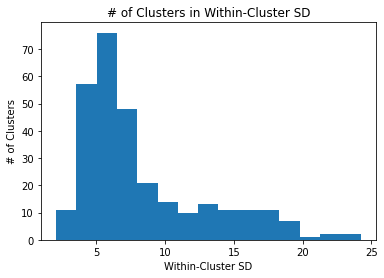

8.300873802949297
8.346122597861664


In [274]:
speed_variance_by_tract = speeds_to_tract.groupby(['MOVEMENT_ID'],as_index=False)[["speed_mph_mean"]].std().speed_mph_mean# compute traffic speed variance in each plus code region

# plot a histogram 
plt.title("# of Clusters in Within-Cluster SD")
plt.ylabel("# of Clusters")
plt.xlabel("Within-Cluster SD")
_ = plt.hist(speed_variance_by_tract.to_numpy(), bins='auto') #cluster index y = corresponding sd
plt.show()

average_variance_by_tract = speed_variance_by_tract.mean()
variance_average_by_tract = speeds_to_tract.groupby(['MOVEMENT_ID'],as_index=False)[["speed_mph_mean"]].apply(lambda x : x.mean()).std().speed_mph_mean
print(average_variance_by_tract)
print(variance_average_by_tract)

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1civ3
points: 3
-->

In [275]:
speed_variance_by_tract

0       3.821144
1       5.522853
2       3.640453
3       6.634154
4       3.838873
         ...    
290     3.379664
291     5.787065
292     4.617596
293    13.191079
294     7.136608
Name: speed_mph_mean, Length: 295, dtype: float64

In [276]:
grader.check("q1civ3")

q1civ3 results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.d. What would be the ideal spatial clustering?

This is an active research problem in many spatiotemporal modeling communities, and there is no single agreed-upon answer. Answer both of the following specifically knowing that you'll need to analyze traffic patterns according to this spatial clustering:

1. **What is a good metric for a spatial structure?** How do we define good? Bad? What information do we expect a spatial structure to yield? Use the above parts and questions to help answer this.
2. **What would you do to optimize your own metric for success in a spatial structure?**

See related articles:

- Uber's H3 [link](https://eng.uber.com/h3/), which divides the world into hexagons
- Traffic Analysis Zones (TAZ) [link](https://en.wikipedia.org/wiki/Traffic_analysis_zone), which takes census data and additionally accounts for vehicles per household when dividing space

<!--
BEGIN QUESTION
name: q1d
points: 3
manual: True
-->

1. A good metric is like selecting shapes that fits the context. From above, we selected by rectangular grids to cluster data by latitude and longitude and that makes sense since regions similar in geography would have similar speed in mph. We know that because ususally neighborhoods have a similar low speed limit and highway zones have like a way higher speed limit. So finding metric according to geography and finding differences between subpopulations will help us to find the appropriate good metric. We expect a spatial structure to yield information about differences between subpopulation and differences within each subpopulation. The bad metrics yield lower variance average and larger average variance while good metrics yield higher variance average and lower average variance. For good metric, we generally want clusters to be distinct from each other and have similar data in each cluster.
2.I would divide up my regions into hexagons instead of grids like the Uber's H3 link with a hierarchical indexing system because grids don't usually align with a neighborhood or streets's shape. Hexagons also have properties that greatly simplifies performing analysis and smoothing over gradients. The hierarchichal index system faciliates efficient indexing.

<!-- END QUESTION -->



# Step 2 - Guided EDA: Understanding COVID Lockdown Impact on Traffic

In this step, we'll examine the impact of COVID on traffic. In particular, we'll study 3 different questions:

- How did lockdown affect traffic speed? What factors dictate how much lockdown affected traffic speed?
- What areas of traffic were most impacted by lockdown?

## 2.a. How did lockdown affect traffic speed?

<!-- BEGIN QUESTION -->

### 2.a.i. Sort census tracts by average speed, pre-lockdown.

Consider the pre-lockdown period to be March 1 - 13, before the first COVID-related restrictions (travel bans) were announced on March 14, 2020.

1. **Report a DataFrame which includes the *names* of the 10 census tracts with the lowest average speed**, along with the average speed for each tract.
2. **Report a DataFrame which includes the *names* of the 10 census tracts with the highest average speed**, along with the average speed for each tract.
2. Do these names match your expectations for low speed or high speed traffic pre-lockdown?  What relationships do you notice? (What do the low-speed areas have in common? The high-speed areas?) For this specific question, answer qualitatively. No need to quantify. **Hint**: Look up some of the names on a map, to understand where they are.
3. **Plot a histogram for all average speeds, pre-lockdown**.
4. You will notice a long tail distribution of high speed traffic. What do you think this corresponds to in San Francisco? Write down your hypothesis.

Hint: To start off, think about what joins may be useful to get the desired DataFrame.

<!--
BEGIN QUESTION
name: q2ai1
points: 3
manual: True
-->

The low speed results matched my expectations, as they are all in San Francisco, which is known for having a lot of traffic which would mean their average speed would low. The high speed results were a little more surprising, as at first they did not seem to have any clear pattern. But after looking at the streets themselves, there seems to be some correlation between these streets. The main thing that stood out to me that was similar about the streets with the high speed traffic was that they all seemed to be large streets that were away from residential areas. This could explain the higher average speed, as streets near residential areas have lower speed limits and since these streets are not near residential areas, they can go at higher speeds.
I would say that none of the high speed areas on the histogram would correspond to areas that are not near San Francisco, because I think on average San Francisco would be on the lower side.

<!-- END QUESTION -->

Answer the following question:
<!--
BEGIN QUESTION
name: q2ai2
points: 3
-->

In [277]:
# compute the average speed per census tract (will use this later),
# BEFORE the shelter-in-place was announced on March 14, 2020.
# Autograder expects this to be a series
truncated = speeds_to_tract[['MOVEMENT_ID', 'speed_mph_mean', 'day']]
filtered = truncated[truncated['day'] < 14].iloc[:, :2]
grouped = filtered.groupby('MOVEMENT_ID').mean()
averages_pre = grouped['speed_mph_mean']
# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
truncated_2 = speeds_to_tract[['MOVEMENT_ID', 'DISPLAY_NAME', 'geometry']]
merge = grouped.merge(truncated_2, on = 'MOVEMENT_ID')
averages_pre_named = merge.drop_duplicates(subset = ['MOVEMENT_ID']).reset_index()[['DISPLAY_NAME', 'geometry', 'speed_mph_mean']]
averages_pre_named

,DISPLAY_NAME,geometry,speed_mph_mean
0,"500 Hyde Street, Tenderloin, San Francisco",POINT (-122.41568 37.78547),14.585102
1,"900 Sutter Street, Lower Nob Hill, San Francisco",POINT (-122.41678 37.78787),15.679922
2,"3400 Pierce Street, Marina District, San Franc...",POINT (-122.43791 37.80061),14.292445
3,"1700 Egbert Avenue, Bayview, San Francisco",POINT (-122.39906 37.71941),23.353083
4,"1400 Thomas Avenue, Bayview, San Francisco",POINT (-122.38343 37.72974),16.213552
...,...,...,...
290,"800 Hacienda Way, Millbrae",POINT (-122.41621 37.60090),20.746333
291,"1900 Buchanan Street, Western Addition, San Fr...",POINT (-122.43000 37.78651),17.042386
292,"2200 Rivera Street, Sunset District, San Franc...",POINT (-122.48656 37.74445),20.029011
293,"300 Ponderosa Road, Avalon, South San Francisco",POINT (-122.43950 37.63646),32.184422


In [278]:
grader.check("q2ai2")

q2ai2 results: All test cases passed!

Report the lowest 10 census tracts with the lowest average speed
Remember we want the NAME of each census tract too. For the autograder, please keep the name of the speed field, `speed_mph_mean`.

<!--
BEGIN QUESTION
name: q2ai3
points: 1
-->

In [279]:
bottom10_averages_pre = averages_pre_named.sort_values('speed_mph_mean').head(10)
bottom10_averages_pre

,DISPLAY_NAME,geometry,speed_mph_mean
166,"200 O'Farrell Street, Tenderloin, San Francisco",POINT (-122.40979 37.78667),12.417079
249,"0 Mason Street, Tenderloin, San Francisco",POINT (-122.41315 37.78100),12.595120
163,"1100 Taylor Street, Nob Hill, San Francisco",POINT (-122.40918 37.79205),12.945291
59,"2900 22nd Street, Mission District, San Francisco",POINT (-122.40946 37.75600),13.195865
51,"200 Myrtle Street, Tenderloin, San Francisco",POINT (-122.41792 37.78518),13.490311
164,"200 Sutter Street, Financial District, San Fra...",POINT (-122.40531 37.78901),13.502505
99,"800 Jackson Street, Chinatown, San Francisco",POINT (-122.40755 37.79226),13.549474
100,"500 Geary Street, Tenderloin, San Francisco",POINT (-122.40994 37.78743),13.570625
52,"200 Jones Street, Tenderloin, San Francisco",POINT (-122.41078 37.78322),13.626251
158,"200 Hyde Street, Tenderloin, San Francisco",POINT (-122.41388 37.78187),13.944773


In [280]:
grader.check("q2ai3")

q2ai3 results: All test cases passed!

Report the highest 10 census tracts with the highest average speed.

<!--
BEGIN QUESTION
name: q2ai4
points: 1
-->

In [281]:
top10_averages_pre = averages_pre_named.sort_values('speed_mph_mean', ascending = False).head(10)
top10_averages_pre

,DISPLAY_NAME,geometry,speed_mph_mean
23,"1600 Maritime Street, Oakland",POINT (-122.32294 37.82261),59.498552
36,"4200 Shelter Creek Lane, San Bruno",POINT (-122.42460 37.61790),53.867847
155,"Petrolite Street, Richmond",POINT (-122.37674 37.92725),47.318340
248,"Frenchmans Creek Road, Half Moon Bay",POINT (-122.42587 37.60134),47.225137
199,"1200 Helen Drive, Millbrae",POINT (-122.41932 37.59630),45.492292
231,"0 Crystal Springs Terrace, Hillsborough Park, ...",POINT (-122.37209 37.54745),44.304919
288,"0 Burgess Court, Sausalito",POINT (-122.50709 37.87027),43.848188
222,"Liccicitos Road, Moss Beach",POINT (-122.51360 37.54618),42.784267
191,"0 Longview Drive, Westlake, Daly City",POINT (-122.48227 37.66650),40.587037
198,"600 San Bruno Avenue East, San Bruno",POINT (-122.40548 37.63088),38.944079


In [282]:
grader.check("q2ai4")

q2ai4 results: All test cases passed!

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2ai5
points: 1
manual: True
-->

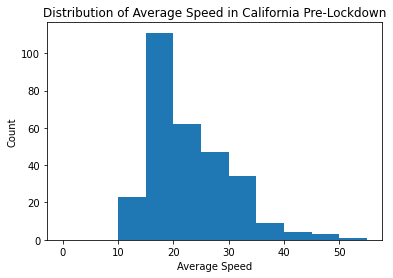

In [283]:
plt.hist(averages_pre, bins=np.arange(0,60,5));
plt.xlabel('Average Speed');
plt.ylabel('Count');
plt.title('Distribution of Average Speed in California Pre-Lockdown');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.ii. Sort census tracts by average speed, post-lockdown.

I suggest checking the top 10 and bottom 10 tracts by average speed, post-lockdown. Consider the post-lockdown period to be March 14 - 31, after the first COVID restrictions were established on March 14, 2020. It's a healthy sanity check. For this question, you should report:

- **Plot a histogram for all average speeds, post-lockdown.**
- **What are the major differences between this post-lockdown histogram relative to the pre-lockdown histogram above**? Anything surprising? What did you expect, and what did you find?

Write the written answers in the cell below, and the coding answers in the cells after that.

<!--
BEGIN QUESTION
name: q2aii1
points: 1
manual: True
-->

The major differences was that there was more of a spread for the post-lockdown period than the pre-lockdown period, which was very surprising to me. I would have thought that the spread would be less, because people were driving less, but I was wrong, as there were a quite a few that were 50 miles per hour and higher. The peak was also higher than the pre-lockdown period, which again surprised me because I thought there were people not driving, so the peak would be lower. However, after thinking about it, this data makes sense. This is due to the fact that because there were on average probably less people driving at one road at a time, people could move faster because there was less traffic. After taking this fact into account, the data started making a lot more sense to me.

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q2aii2
points: 2
-->

In [284]:
# compute the average speed per census tract (will use this later),
# AFTER (and including) the first COVID restrictions were put into effect.
# Autograder expects this to be a series
truncated_post = speeds_to_tract[['MOVEMENT_ID', 'speed_mph_mean', 'day']]
filtered_post = truncated_post[truncated_post['day'] >= 14].iloc[:, :2]
grouped_post = filtered_post.groupby('MOVEMENT_ID').mean()
averages_post = grouped_post['speed_mph_mean']
# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
truncated_2_post = speeds_to_tract[['MOVEMENT_ID', 'DISPLAY_NAME', 'geometry']]
merge_post = grouped_post.merge(truncated_2_post, on = 'MOVEMENT_ID')
averages_post_named = merge_post.drop_duplicates(subset = ['MOVEMENT_ID']).reset_index()[['DISPLAY_NAME', 'geometry', 'speed_mph_mean']]
averages_post_named

,DISPLAY_NAME,geometry,speed_mph_mean
0,"500 Hyde Street, Tenderloin, San Francisco",POINT (-122.41568 37.78547),16.143154
1,"900 Sutter Street, Lower Nob Hill, San Francisco",POINT (-122.41678 37.78787),16.871488
2,"3400 Pierce Street, Marina District, San Franc...",POINT (-122.43791 37.80061),15.754795
3,"1700 Egbert Avenue, Bayview, San Francisco",POINT (-122.39906 37.71941),25.956602
4,"1400 Thomas Avenue, Bayview, San Francisco",POINT (-122.38343 37.72974),16.476000
...,...,...,...
280,"800 Hacienda Way, Millbrae",POINT (-122.41621 37.60090),17.917000
281,"1900 Buchanan Street, Western Addition, San Fr...",POINT (-122.43000 37.78651),22.128519
282,"2200 Rivera Street, Sunset District, San Franc...",POINT (-122.48656 37.74445),23.440404
283,"300 Ponderosa Road, Avalon, South San Francisco",POINT (-122.43950 37.63646),38.807594


In [285]:
grader.check("q2aii2")

q2aii2 results: All test cases passed!

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2aii3
points: 1
manual: True
-->

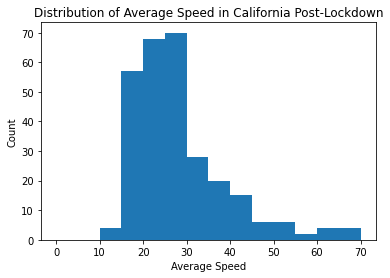

In [286]:
plt.hist(averages_post, bins = np.arange(0, 75, 5));
plt.xlabel('Average Speed');
plt.ylabel('Count');
plt.title('Distribution of Average Speed in California Post-Lockdown');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iii. Sort census tracts by change in traffic speed from pre to post lockdown.

For each segment, compute the difference between the pre-lockdown average speed (March 1 - 13) and the post-lockdown average speed (March 14 - 31). **Plot a histogram of all differences.** Sanity check that the below histogram matches your observations of the histograms above, on your own.

<!--
BEGIN QUESTION
name: q2aiii
points: 2
manual: True
-->

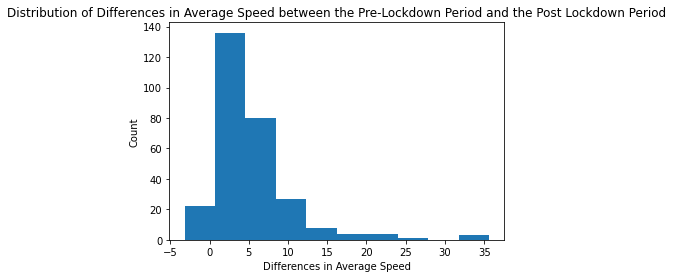

In [287]:
# The autograder expects differences to be a series object with index
# MOVEMENT_ID.
differences = averages_post - averages_pre
differences
plt.hist(differences);
plt.xlabel('Differences in Average Speed');
plt.ylabel('Count');
plt.title('Distribution of Differences in Average Speed between the Pre-Lockdown Period and the Post Lockdown Period');

# plot the differences

In [288]:
grader.check("q2aiii")

q2aiii results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iv. Quantify the impact of lockdown on average speeds.

1. **Plot the average speed by day, across all segments**. Be careful not to plot the average of census tract averages instead. Recall the definition of segments from Q1.
2. Is the change in speed smooth and gradually increasing? Or increasing sharply? Why? Use your real-world knowledge of announcements and measures during that time, in your explanation. You can use this list of bay area COVID-related dataes: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/

<!--
BEGIN QUESTION
name: q2aiv1
points: 1
manual: True
-->

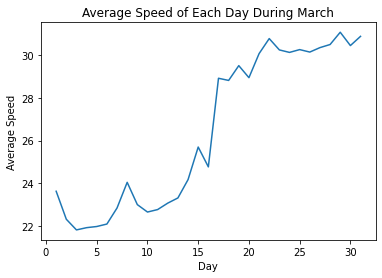

In [289]:
# Autograder expects this to be a series object containing the
# data for your line plot -- average speeds per day.
line_graph_data = speeds_to_tract[['day', 'speed_mph_mean']].groupby('day').mean()
speeds_daily = line_graph_data['speed_mph_mean']
indexes = line_graph_data.index
values = line_graph_data.values
plt.plot(indexes, values);
plt.xlabel('Day');
plt.ylabel('Average Speed');
plt.title('Average Speed of Each Day During March');


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Write your written answer in the cell below

<!--
BEGIN QUESTION
name: q2aiv2
points: 1
manual: True
-->

The change in speed is not smooth, but increases very steeply. I feel like this is vecause the time period before COVID, which is about the first half of the month, traffic was regular so average speed was relatively the same. However when COVID happened, there was a little dip, and then there was a steep increase. This steep increase can be traced back to two reasons. The first reason is due to the fact that there are less people driving, meaning that the roads are less congested. This would mean that people can drive faster. ANother reason is that the reasoning for drivin during this time would be for emergency purposes only, such as driving to the hospital and getting supplies. People would want to do these tasks as fast as possible, so they would porbably drive faster, which could be another reason for why the average speed was high.

<!-- END QUESTION -->

Ignore the empty cell below, just run the autograder to test the code above is correct.
<!--
BEGIN QUESTION
name: q2aiv3
points: 1
-->

In [290]:
grader.check("q2aiv3")

q2aiv3 results: All test cases passed!

<!-- BEGIN QUESTION -->

### 2.a.v. Quantify the impact of pre-lockdown average speed on change in speed.

1. Compute the correlation between change in speed and the *pre*-lockdown average speeds. Do we expect a positive or negative correlation, given our analysis above?
2. Compute the correlation between change in speed and the post-lockdown average speeds.
3. **How does the correlation in Q1 compare with the correlation in Q2?** You should expect a significant change in correlation value. What insight does this provide about traffic?

Written answers in the first cell, coding answerts in the following cell.

<!--
BEGIN QUESTION
name: q2av1
points: 2
manual: True
-->

q1. I expected there to be a positive correlation between change in speed and the pre-lockdown average speeds. 


q3. The correlation in Q1 is smaller than the correlation in Q2. This shows me that the the differences are more in line with Q2, and since the differences are just the post lockdown speeds - the pre-lockdown speeds, an increased correlation could indicate that there are on average higher values for the post-lockdown average speeds. It says about the traffic that as there is an increase in differences between post-lockdown avg speeds and pre-lockdown avg speeds, there is an increase in the average post-lockdown average speeds.


<!-- END QUESTION -->


<!--
BEGIN QUESTION
name: q2av2
points: 2
-->

In [291]:
d = {'col1': differences, 'col2': averages_pre}
df = pd.DataFrame(data=d)
corr_pre_diff = df.corr().iloc[0, 1]#np.corrcoef(differences, averages_pre)
d2 = {'col1': differences, 'col2': averages_post}
df2 = pd.DataFrame(data=d2)
corr_post_diff = df2.corr().iloc[0, 1]
corr_pre_diff, corr_post_diff

(0.4633006380580185, 0.792679998478066)

In [292]:
grader.check("q2av2")

q2av2 results: All test cases passed!

## 2.b. What traffic areas were impacted by lockdown?

<!-- BEGIN QUESTION -->

### 2.b.i. Visualize spatial heatmap of average traffic speed per census tract, pre-lockdown.

Visualize a spatial heatmap of the grouped average daily speeds per census tract, which you computed in previous parts. Use the geopandas [chloropleth maps](https://geopandas.org/docs/user_guide/mapping.html#choropleth-maps). **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest**. These may be a local extrema, or a region that is strangely all similar.

**Hint**: Use [`to_crs`](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.to_crs.html) and make sure the `epsg` is using the Pseudo-Mercator projection.

**Hint**: You can use `contextily` to superimpose your chloropleth map on a real geographic map.

**Hint** You can set a lower opacity for your chloropleth map, to see what's underneath, but be aware that if you plot with too low of an opacity, the map underneath will perturb your chloropleth and meddle with your conclusions.

Written answers in the first cell, coding answers in the second cell.

<!--
BEGIN QUESTION
name: q2bi1
points: 1
manual: True
-->

Something that I found very interesting is how this heatmap sort of grows in magnitude through ripples. What I mean by this is that the middle, which is around San Francisco, is relatively small, and then as you go further from that the average speed gets larger and larger. One other point of interest for me was the top right of the graph. This part of the graph has the highest average speed, which was something I would not have expected and surprised me a lot.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bi2
points: 4
manual: True
-->

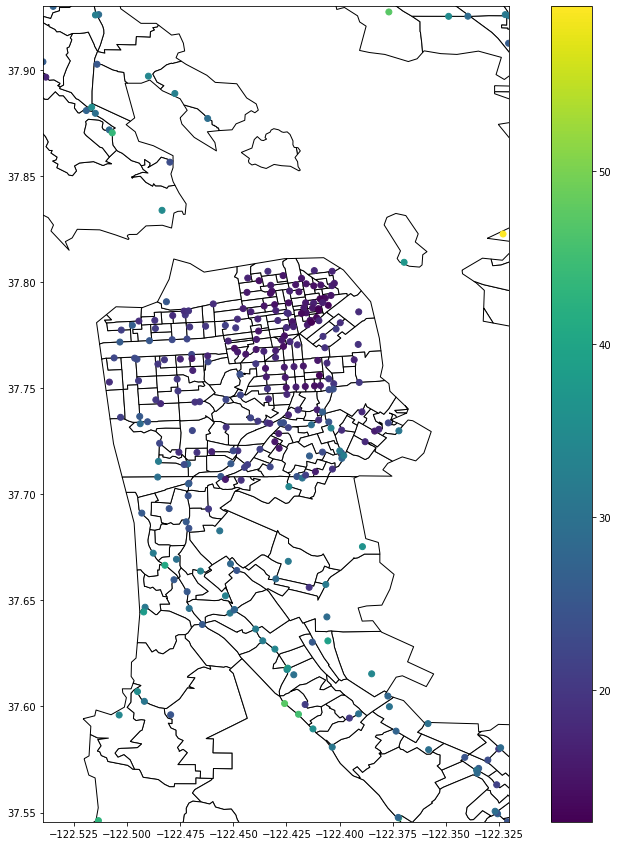

In [293]:
d = {'DISPLAY_NAME': averages_pre_named['DISPLAY_NAME'], 'geometry': averages_pre_named['geometry'], 'speed_mph_mean': averages_pre_named['speed_mph_mean']}
gdf = gpd.GeoDataFrame(d, crs=4326).set_crs(epsg=3857, inplace=True, allow_override=True)
base = tract_to_gps.plot(color = 'white', edgecolor = 'black',figsize=(15, 15)) 
minx, miny, maxx, maxy = gdf.total_bounds
speed_plot = gdf.plot(ax = base , column = 'speed_mph_mean', legend = True)
speed_plot.set_xlim(minx, maxx)
speed_plot.set_ylim(miny, maxy)
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.b.ii. Visualize change in average daily speeds pre vs. post lockdown.

Visualize a spatial heatmap of the census tract differences in average speeds, that we computed in a previous part. **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest.** Some possible ideas for interesting notes: Which areas saw the most change in average speed? Which areas weren't affected? Why did some areas see *reduced* average speed?

First cell is for the written answers, second cell is for the coding answers.

<!--
BEGIN QUESTION
name: q2bii1
points: 1
manual: True
-->

Something that I found very interesting is how this heatmap sort of grows in magnitude through ripples. WHat I mean by this is that the middle, which is around San Francisco, is realtively samll, and then as you go further from that the average speed gets larger and larger. One other point of interest for me was the top right of the graph. This part of the graph has the highest average speed, which was something I would not have expected and surprised me a lot.

I think that it is interesting that near the San Francisco area, the values are near 0 fro the dfference, which surprised me. I would have thought that there would be some difference, but this heat map is showing that there is next to no difference between the two. The second thing that was interesting to me was that as you go down, it got darker, which means the first half of March had higher speeds than the second half of March, which is not waht I would have thought would happen.


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bii2
points: 4
manual: True
-->

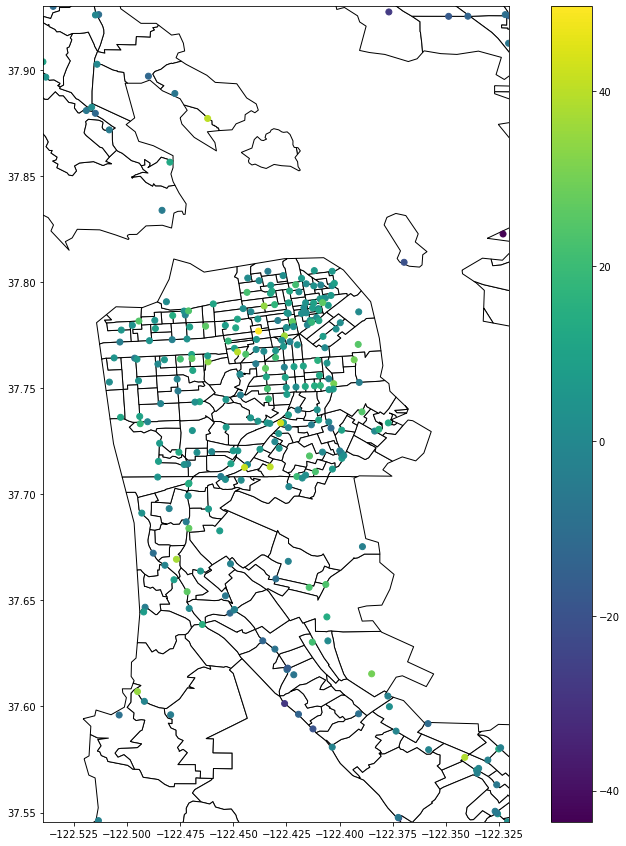

In [294]:
averages_pre_named['differences'] = averages_post_named['speed_mph_mean'] - averages_pre_named['speed_mph_mean']

d_2 = {'DISPLAY_NAME': averages_pre_named['DISPLAY_NAME'], 'geometry': averages_pre_named['geometry'], 'differences': averages_pre_named['differences']}
gdf_2 = gpd.GeoDataFrame(d_2, crs=4326).set_crs(epsg=3857, inplace=True, allow_override=True)
base_2 = tract_to_gps.plot(color = 'white', edgecolor = 'black',figsize=(15, 15))
minx2, miny2, maxx2, maxy2 = gdf_2.total_bounds
speed_plot_2 = gdf_2.plot(ax = base_2 , column = 'differences', legend = True)
speed_plot_2.set_xlim(minx2, maxx2)
speed_plot_2.set_ylim(miny2, maxy2)
plt.show();


<!-- END QUESTION -->



# Step 3 - Open-Ended EDA: Understanding lockdown impact on travel times

Explore daily travel times from Hayes Valley to other destinations both before and throughout lockdown. Use the following questions as suggestions for what to explore, temporally and spatially:

- How did lockdown affect travel times? Are there any meaningful factors that determined how travel time would be impacted? How was travel time affected over time?
- Travel to which destinations were affected by lockdown? Are there surprisingly disproportionate amounts of impact in certain areas?

## 3.a. Load Datasets

In this step, we will load two datasets:

- Daily travel times from Hayes Valley to all other census tracts around San Francisco.
- Daily travel times from 300 Hayes St to Golden Gate Park in San Francisco.

For this specific set of data, we can ask several more questions; which questions you pursue are up to you, including any that you come up that are not on this list:

- Which routes from Hayes Valley had similar impact on travel time? Did they share any factors in common? Traveling through the same place -- e.g., a freway? Traveling in similar areas e.g., residential areas?
- Were clusters of routes impacted more severely than others over time? What determined the degree of impact?

In [295]:
'''
speeds_to_tract_mod=speeds_to_tract.drop_duplicates(subset = ['MOVEMENT_ID']).reset_index()
'''

"\nspeeds_to_tract_mod=speeds_to_tract.drop_duplicates(subset = ['MOVEMENT_ID']).reset_index()\n"

In [296]:
PATH_TIMES = 'data/travel-times-daily-san-francisco-2020-3.csv'
times_to_tract = pd.read_csv(PATH_TIMES)
times_to_tract
'''
times_to_tract= pd.merge(left=times_to_tract, right=speeds_to_tract_mod, left_on=["Destination Movement ID"], right_on=['MOVEMENT_ID'])
#times_to_tract[times_to_tract["Destination Movement ID"]==9]

#beforeQuarentine = times_to_tract.loc[times_to_tract['day'] < 14]
afterQuarentine = times_to_tract.loc[times_to_tract['day_x'] >= 14]
#beforeQuarentine = beforeQuarentine.rename(columns={'Mean Travel Time (Seconds)': 'Mean_Travel_Time_BQ_Seconds'})
afterQuarentine = afterQuarentine.rename(columns={'Mean Travel Time (Seconds)': 'Mean_Travel_Time_AQ_Seconds'})
#meanTravelBefore = beforeQuarentine.groupby('Destination Movement ID')['Mean_Travel_Time_BQ_Seconds'].mean()
afterQuarentine
'''

'\ntimes_to_tract= pd.merge(left=times_to_tract, right=speeds_to_tract_mod, left_on=["Destination Movement ID"], right_on=[\'MOVEMENT_ID\'])\n#times_to_tract[times_to_tract["Destination Movement ID"]==9]\n\n#beforeQuarentine = times_to_tract.loc[times_to_tract[\'day\'] < 14]\nafterQuarentine = times_to_tract.loc[times_to_tract[\'day_x\'] >= 14]\n#beforeQuarentine = beforeQuarentine.rename(columns={\'Mean Travel Time (Seconds)\': \'Mean_Travel_Time_BQ_Seconds\'})\nafterQuarentine = afterQuarentine.rename(columns={\'Mean Travel Time (Seconds)\': \'Mean_Travel_Time_AQ_Seconds\'})\n#meanTravelBefore = beforeQuarentine.groupby(\'Destination Movement ID\')[\'Mean_Travel_Time_BQ_Seconds\'].mean()\nafterQuarentine\n'

# Step 4 - Guided Modeling: Predict traffic speed post-lockdown

In this step, you'll train a model to predict traffic speed. In particular, you'll learn how to provide implicit supervision and correction to your model, when you know there's been a distribution shift in its data, leading to a large gap between train and test sets. You'll follow the following outline:

- Build a model to predict daily traffic speed in San Francisco. Train and evaluate on *pre*-lockdown traffic speeds around the city.
- Evaluate your model on post-lockdown traffic speeds. Where is your model most mistaken, and why?
- Using this knowledge, how would you correct your model for a more accurate post-lockdown traffic predictor?


The technical term for a phenomenon like the lockdown, which caused major distributional shifts in the data, is *change point*. A large body of work studies "change point detection," but you'll be harder pressed to find a "handling change point" paper. 

## 4.a. Predict daily traffic speed on pre-lockdown data

For your model, you will predict daily traffic speed per census tract, given the previous $k=5$ daily traffic speeds for that census tract. In particular, say a matrix $A$ is $n \times d$, where $n$ is the number of census tracts and $d$ is the number of days. We define the following inputs and labels:

$$X_{(i,t)} = [A_{(i,t-5)}, A_{(i,t-4)}, A_{(i,t-3)}, A_{(i,t-2)}, A_{(i,t-1)}]$$
$$y_{(i,t)} = [A_{(i,t)}]$$

This just means that each sample $X_i$ includes speed averages from the previous 5 days for the $i$th census track.

### 4.a.i. Assemble dataset to predict daily traffic speed.

Below, we've included skeletons for the helper functions we defined, to complete the problem. We highly recommend following this skeleton code, else we cannot guarantee staff support for debugging your work.


**Hint**: What's wrong with collecting all samples, then randomly selecting some percentage to hold out? See the answer in the expandable below.

<details>
    <summary>[Click to expand] How to do train-validation split correctly, on time series</summary>
    
For a *time series* in particular, this random split would be cheating, because data within each day is highly correlated. Instead, you should hold out entire days from the dataset. In this case, you should hold out the last 2 days for your validation set.
</details>

<!--
BEGIN QUESTION
name: q4ai1
points: 1
-->

In [297]:
def dataframe_to_time_series(df: pd.DataFrame):
    """Convert your dataframe into a 'time series'.
    
    :param df: the original dataframe, mapping speeds to census tracts.
        This dataframe should contain the `MOVEMENT_ID` (census tract id),
        `day`, and average speed for that day `speed_mph_mean`
    :return: a new dataframe that is formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    """
    b = df.set_index(['MOVEMENT_ID', 'day'], inplace=False)[["speed_mph_mean"]].groupby(['MOVEMENT_ID', 'day']).mean()
    return b.unstack(level = -1)
time_series = dataframe_to_time_series(speeds_to_tract)
time_series_pre = time_series.iloc[:, list(range(13))]

In [298]:
grader.check("q4ai1")

q4ai1 results: All test cases passed!

In [299]:
def time_series_to_numpy(df: pd.DataFrame, T: int, n_val: int):
    """Convert your 'time series' into train-validate splits, in numpy
    
    You can assume your dataframe contains a `day` column where days
    start from 1 and are consecutive.
    
    :param df: the dataframe formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    :param T: number of days to include in each training sample
    :param n_val: number of days to hold out for the validation set.
        Say we have 5 total days in our dataset, T=2, n_val=2. This means
        during training, we have samples that pull averages from days 1 and
        2 to predict day 3: x=(1, 2), y=(3,) For validation, we have samples
        like x=(2, 3), y=(4,) and x=(3, 4), y=(5,). This way, the model sees
        data from days 4 and 5 only during validation.
    :return: Set of 4 numpy arrays - X_train, y_train, X_val, y_val - where
        X_* arrays are (n, T) and y_* arrays are (n,).
    """
    numOfDaysTotal = len(df.columns)
    X_train = np.zeros(shape=(df.shape[0] * (numOfDaysTotal - n_val - T),T))
    y_train= np.zeros(shape=(df.shape[0] * (numOfDaysTotal - n_val - T), ))
    for census in range(df.shape[0]):
        for i in range((numOfDaysTotal - n_val - T)):
            X_train[census * (numOfDaysTotal - n_val - T) + i] = df.iloc[census, i:i + T].to_numpy()
            y_train [census * (numOfDaysTotal - n_val - T) + i] = df.iloc[census, i + T]
    
    X_val = np.zeros(shape=(df.shape[0] *n_val, T))
    y_val= np.zeros(shape=(df.shape[0]*n_val, ))
    for census in range(df.shape[0]): 
        for i in range(n_val):
            X_val[census * n_val + i] = df.iloc[census, -1-i- T:-1-i].to_numpy()
            y_val [census * n_val + i] = df.iloc[census, -1-i]
    return X_train, y_train, X_val, y_val
    
import math
def remove_nans(X: np.array, y: np.array):
    """Remove all nans from the provided (X, y) pair.
    
    Note: A nan in X means that sample must be removed from *both X and y.
        Likewise, a nan in y means that sample must be removed from *both
        X and y.
    
    :param X: (n, T) array of model inputs
    :param y: (n,) array of labels
    :return: (X, y)
    """
    if not len(X):
        return X, y
    mask = ~np.any(np.isnan(X), axis=1)
    X = X[mask]
    y = y[mask]
    mask = ~np.isnan(y)
    X = X[mask]
    y = y[mask]
    return X,y
answer = time_series_to_numpy(time_series, 10, 2)
answer2 = remove_nans(answer[0], answer[1])

In [300]:
grader.check("q4ai2")

q4ai2 results: All test cases passed!

In [301]:
def time_series_to_dataset(time_series: pd.DataFrame, T: int, n_val: int):
    """Convert 'time series' dataframe to a numpy dataset.
    
    Uses utilites above `time_series_to_numpy` and `remove_nans`
    
    For description of arguments, see `time_series_to_numpy` docstring.
    """
    answer = time_series_to_numpy(time_series, T, n_val)
    X_train, y_train = remove_nans(answer[0], answer[1])
    X_val, y_val = remove_nans(answer[2], answer[3])
    return X_train, y_train, X_val, y_val
X_train, y_train, X_val, y_val = time_series_to_dataset(time_series_pre, 5, 2)

In [302]:
grader.check("q4ai3")

q4ai3 results: All test cases passed!

In [303]:
time_series

speed_mph_mean                                              \
day                     1          2          3          4          5    
MOVEMENT_ID                                                              
9                16.196918  14.395121  13.868696  14.225414  14.312199   
20               17.418045  15.460956  15.463297  15.419764  15.291956   
21               15.141171  13.176998  13.781490  14.052113  14.078134   
44               25.079544  23.492586  22.727711  22.274143  21.874703   
78               16.174464  16.755496  16.039120  16.118401  15.665069   
...                    ...        ...        ...        ...        ...   
2691                   NaN        NaN        NaN        NaN  18.600000   
2694             17.809761  16.725889  16.530783  16.446517  16.503053   
2695             20.106061  20.228850  19.849135  20.145877  22.357605   
2700             34.586890  31.372308  30.866382  31.000998  31.636377   
2708             25.176235  24.725863  24.130040  24.287102  24.364056   

                                                                    ...  \
day                 6          7          8          9          10  ...   
MOVEMENT_ID                                                         ...   
9            13.811991  15.508637  16.210738  14.845320  14.711534  ...   
20           15.227310  17.088325  18.088862  16.178105  15.295494  ...   
21           13.636357  13.958269  14.642295  15.616215  14.850471  ...   
44           23.082414  22.875819  25.653848  23.501387  22.739869  ...   
78           15.797723  15.302616  19.284080  16.253357  16.131290  ...   
...                ...        ...        ...        ...        ...  ...   
2691         17.787000  23.473000        NaN  19.038000        NaN  ...   
2694         16.652473  17.427329  18.057287  17.310272  16.998730  ...   
2695         19.250479  19.223717  19.471282  20.497077  20.401085  ...   
2700         30.213992  33.581884  35.443617  32.179867  32.951855  ...   
2708         25.090063  25.552157  26.296112  25.512403  24.886063  ...   

                                                                               \
day                 22         23         24         25         26         27   
MOVEMENT_ID                                                                     
9            15.880078  17.019573  15.527393  15.925605  15.959744  17.317841   
20           18.843376  17.029943  16.286795  17.007889  15.205696  17.461643   
21                 NaN        NaN        NaN        NaN        NaN        NaN   
44           24.381933  25.350188  31.126033        NaN  22.518500  27.697570   
78                 NaN        NaN  15.690000        NaN        NaN  16.849000   
...                ...        ...        ...        ...        ...        ...   
2691               NaN        NaN        NaN        NaN        NaN        NaN   
2694         23.886576  23.410192  23.302396  23.031966  23.107702  23.581885   
2695         29.218800        NaN        NaN        NaN  23.396500        NaN   
2700         47.265544  39.722920  42.812205  39.087122  54.935270  40.893501   
2708               NaN  19.323625  27.792333  25.255979  25.388000  24.786000   

                                                         
day                 28         29         30         31  
MOVEMENT_ID                                              
9            17.845053  17.839214  15.743376  15.797248  
20           16.997424  19.024721  14.134949  17.287814  
21                 NaN        NaN        NaN        NaN  
44           26.899667  19.777429  24.385409  24.683422  
78                 NaN        NaN  16.493000  16.767400  
...                ...        ...        ...        ...  
2691               NaN        NaN        NaN        NaN  
2694         24.382866  23.278001  23.426889  24.056357  
2695         19.708000  26.461900        NaN  19.959500  
2700         45.208787  60.177978  38.714434  48.398038  
2708         27.643333  27.497250  

In [304]:
time_series_pre

speed_mph_mean                                              \
day                     1          2          3          4          5    
MOVEMENT_ID                                                              
9                16.196918  14.395121  13.868696  14.225414  14.312199   
20               17.418045  15.460956  15.463297  15.419764  15.291956   
21               15.141171  13.176998  13.781490  14.052113  14.078134   
44               25.079544  23.492586  22.727711  22.274143  21.874703   
78               16.174464  16.755496  16.039120  16.118401  15.665069   
...                    ...        ...        ...        ...        ...   
2691                   NaN        NaN        NaN        NaN  18.600000   
2694             17.809761  16.725889  16.530783  16.446517  16.503053   
2695             20.106061  20.228850  19.849135  20.145877  22.357605   
2700             34.586890  31.372308  30.866382  31.000998  31.636377   
2708             25.176235  24.725863  24.130040  24.287102  24.364056   

                                                                               \
day                 6          7          8          9          10         11   
MOVEMENT_ID                                                                     
9            13.811991  15.508637  16.210738  14.845320  14.711534  13.739901   
20           15.227310  17.088325  18.088862  16.178105  15.295494  14.637109   
21           13.636357  13.958269  14.642295  15.616215  14.850471  13.790100   
44           23.082414  22.875819  25.653848  23.501387  22.739869  23.756560   
78           15.797723  15.302616  19.284080  16.253357  16.131290  15.773117   
...                ...        ...        ...        ...        ...        ...   
2691         17.787000  23.473000        NaN  19.038000        NaN        NaN   
2694         16.652473  17.427329  18.057287  17.310272  16.998730  16.891788   
2695         19.250479  19.223717  19.471282  20.497077  20.401085  23.870537   
2700         30.213992  33.581884  35.443617  32.179867  32.951855  31.574525   
2708         25.090063  25.552157  26.296112  25.512403  24.886063  23.902599   

                                   
day                 12         13  
MOVEMENT_ID                        
9            14.391436  13.955833  
20           14.282602  14.437358  
21           14.573349  15.177251  
44           24.989269  23.176275  
78           16.091415  16.208158  
...                ...        ...  
2691         22.107000        NaN  
2694         17.008323  17.559142  
2695         20.215396  20.343131  
2700         32.172958  31.334364  
2708         25.262721  24.450025  

[295 rows x 13 columns]

In [305]:
(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

((1705, 5), (1705,), (562, 5), (562,))

<!-- BEGIN QUESTION -->

### 4.a.ii. Train and evaluate linear model on pre-lockdown data.

1. **Train a linear model that forecasts the next day's speed average** using your training dataset `X_train`, `y_train`. Specifically, predict $y_{(i,t)}$ from $X_{(i,t)}$, where
- $y_{(i,t)}$ is the daily speed average for day $t$ and census tract $i$
- $X_{(i,t)}$ is a vector of daily speed averages for days $t-5,t-4,t-3,t-2,t-1$ for census tract $i$
2. **Evaluate your model** on your validation dataset `X_val`, `y_val`.
3. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

Our model is quantitatively and qualitatively pretty accurate at this point, training and evaluating on pre-lockdown data.

<!--
BEGIN QUESTION
name: q4aii1
points: 1
manual: True
-->

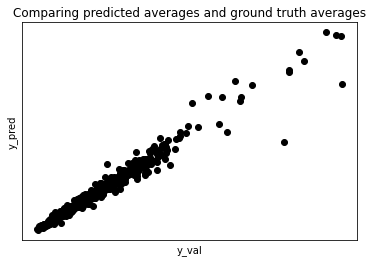

In [306]:
from sklearn import  linear_model
from sklearn.metrics import r2_score
reg =  linear_model.LinearRegression() # set to trained linear model
reg.fit(X_train, y_train)
y_pred_a = reg.predict(X_val)
score = r2_score(y_val, y_pred_a) # report r^2 score
# create the scatter plot below

plt.scatter(y_pred_a, y_val, color="black")
plt.xlabel('y_val');
plt.ylabel('y_pred');
plt.title('Comparing predicted averages and ground truth averages');

plt.xticks(())
plt.yticks(())

plt.show()

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4aii2
points: 1
-->

In [307]:
score

0.9639232922122069

In [308]:
grader.check("q4aii2")

q4aii2 results: All test cases passed!

## 4.b. Understand failures on post-lockdown data

Your dataset is distributed spatially and temporally. As a result, the most intuitive spaces to visualize your model error or performance along is both spatially and temporally. In this step, we focus on understanding *where* your model fails.

### 4.b.i. Evaluate on post-lockdown data

1. Using your previously trained linear regression model `reg`, **evaluate on post-lockdown data**, meaning daily speed averages on March 14, 2020. Evaluate on all census tracts.
2. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

<!--
BEGIN QUESTION
name: q4bi1
points: 1
-->

In [309]:
time_series_x_pre =  time_series.iloc[:, 8:13]# get 'time series' dataframe for days 8, 10, 11, 12, 13
time_series_y_post = time_series.iloc[:, 13] # get 'time series' dataframe for 14th

time_series_x_pre, time_series_y_post = remove_nans(time_series_x_pre, time_series_y_post)
y_pred = reg.predict(time_series_x_pre)
score_pre_14th = r2_score(time_series_y_post.values, y_pred)
score_pre_14th

0.9337122097376678

In [310]:
grader.check("q4bi1")

q4bi1 results: All test cases passed!

In [311]:
time_series_x_pre

speed_mph_mean                                            
day                     9          10         11         12         13
MOVEMENT_ID                                                           
9                14.845320  14.711534  13.739901  14.391436  13.955833
20               16.178105  15.295494  14.637109  14.282602  14.437358
21               15.616215  14.850471  13.790100  14.573349  15.177251
44               23.501387  22.739869  23.756560  24.989269  23.176275
78               16.253357  16.131290  15.773117  16.091415  16.208158
...                    ...        ...        ...        ...        ...
2673             27.019939  26.907395  27.346724  27.833607  28.107019
2694             17.310272  16.998730  16.891788  17.008323  17.559142
2695             20.497077  20.401085  23.870537  20.215396  20.343131
2700             32.179867  32.951855  31.574525  32.172958  31.334364
2708             25.512403  24.886063  23.902599  25.262721  24.450025

[280 rows x 5 columns]

In [312]:
time_series_y_post

MOVEMENT_ID
9       15.878056
20      16.095385
21      15.172252
44      25.006452
78      15.128800
          ...    
2673    29.848889
2694    17.714930
2695    20.321418
2700    33.941697
2708    29.023549
Name: (speed_mph_mean, 14), Length: 280, dtype: float64

<!-- BEGIN QUESTION -->

Make scatter plot below.
<!--
BEGIN QUESTION
name: q4bi2
points: 1
manual: True
-->

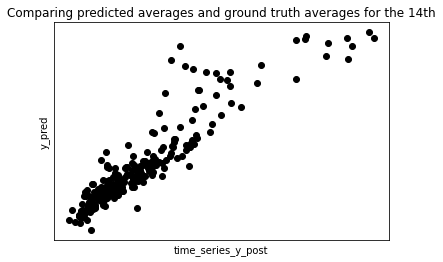

In [330]:
plt.scatter(y_pred, time_series_y_post, color="black")
plt.xlabel('time_series_y_post');
plt.ylabel('y_pred');
plt.title('Comparing predicted averages and ground truth averages for the 14th')

plt.xticks(())
plt.yticks(())

plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 4.b.ii. Report model performance temporally

1. **Make a line plot** showing performance of the original model throughout all of March 2020.
2. **Report the lowest point on the line plot**, reflecting the lowest model performance.
2. **Why is model performance the worst on the 17th?** Why does it begin to worsen on march 15th? And continue to worsen? Use what you know about covid measures on those dates. You may find this webpage useful: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/
3. **Is the dip in performance on the 9th foreshadowed** by any of our EDA?
4. **How does the model miraculously recover on its own?**
5. **Make a scatter plot**, plotting predicted averages against ground truth averages *for model predictions on March 17th*. Note the perfect model would line up all points along the line $y=x$. When compared against previous plots of this nature, this plot looks substantially worse, with points straying far from $y=x$.

**Note:** Answer questions 2-5 in the Markdown cell below. Q1 and Q6 are answered in the two code cells below.

<!--
BEGIN QUESTION
name: q4bii1
points: 3
manual: True
-->



Q2: The lowest point on the line plot is March 17th and it has the lowest score of about 0.73. 
Q3: The model performance is the worst on the 17th because the prediction relies on the previous 5 days in our model and the previous 5 days are pretty regular days until the 17th which is the day in which shelter in place order is announced to take place and that greatly reduced traffic avg speeds. So our predicted avg speed for the 17th is likely to be based on a regular day and the actual avg speed on the 17th is likely to be lower than a regular day since shelter in place is taken place and cars are no longer out on the road. So this difference between expected avg traffic speed and actual avg traffic speed resulted in this lowest point on the line plot. The model performance starts to worsen on the 15th because Governor Gavin orders all bars, nightclubs, wineries, and brewpubs to close, tells adults age 65 and over and those with chronic health conditions to stay home, allows restaurants to stay open but to reduce capacity so customers are socially distanced so avg traffic speeds are starting to be reduced. It continued to worsen after marcg 15th because more cases are being reported and Governor is taking more measures to reduce social gatherings and thus reducing people traveling outside and thus less cars on the roads.
Q4:From q2.a.iv's graph we see a peak on the 8th, which imeans the avg traffic speed peaked on the 8th. This abnormal peak foreshadows the dip in performance of our line plot in this problem as the predicted and actual avg traffic speed differs quite a lot.
Q5: The model miraculously recovers on its own when the model gets adjusted the low traffic speeds after a few days of reduced traffic speed after the 17th. In other words, the model uses the reduced traffic speeds days to predict the later days. So when the model becomes used to the reduced traffic avg speeds, it will predict at a higher accuracy thus the model recovers on its own.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate line plot.
<!--
BEGIN QUESTION
name: q4bii2
points: 1
manual: True
-->

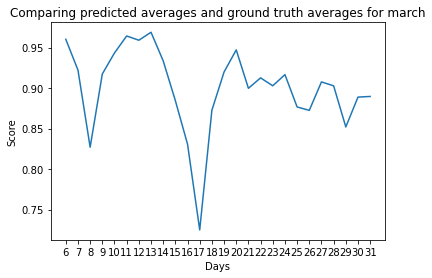

In [331]:
scoreList =[]
for i in range(0, 26):
    time_series_x_pre =  time_series.iloc[:, i:i + 5]# get 'time series' dataframe for the prior five days like 9, 10, 11, 12, 13
    time_series_y_post = time_series.iloc[:, i + 5] # get 'time series' dataframe for the day after the prior five days like the 14th
    time_series_x_pre, time_series_y_post = remove_nans(time_series_x_pre, time_series_y_post)
    y_pred = reg.predict(time_series_x_pre)
    scoreList.append(r2_score(time_series_y_post.values, y_pred))

fig = plt.figure()
ax = plt.axes()
plt.plot(range(6, 32), scoreList)
plt.xlabel('Days')
plt.ylabel('Score')
ax.set_xticks(range(6, 32))
plt.title('Comparing predicted averages and ground truth averages for march');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate a scatter plot.
<!--
BEGIN QUESTION
name: q4bii3
points: 1
manual: True
-->

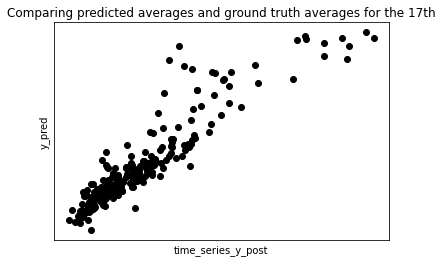

In [332]:
time_series_x_pre =  time_series.iloc[:, 11:16]# get 'time series' dataframe for days 13, 14, 15, 16, 17
time_series_y_post = time_series.iloc[:, 16] # get 'time series' dataframe for 17th

time_series_x_pre, time_series_y_post = remove_nans(time_series_x_pre, time_series_y_post)
y_pred_17 = reg.predict(time_series_x_pre)

plt.scatter(y_pred_17, time_series_y_post, color="black")
plt.xlabel('time_series_y_post');
plt.ylabel('y_pred');
plt.title('Comparing predicted averages and ground truth averages for the 17th')

plt.xticks(())
plt.yticks(())

plt.show()

<!-- END QUESTION -->



## 4.c. "Fix" model on post-lockdown data

Per this survey https://pure.tue.nl/ws/files/3488790/740215.pdf, there are 4 categories of fixes for change points:
- Forgetting mechanisms
- Explicit change detection
- Ensemble techniques
- Context-aware approaches

In this part, we'll combine insights in model errors with previous EDA insights to produce a fix.

<!-- BEGIN QUESTION -->

### 4.c.i. Learn delta off of a moving bias

According to our previous work in EDA, the average speed shoots upwards sharply. As a result, our trick to learn delta the around the average and to naively assume that the average of day $t$ is the average for day $t+1$. We will do this in 4 steps:

1. **Create a dataset for your delta model**.
2. **Train your delta model** on pre-lockdown data.
3. **Evaluate your model on pre-lockdown data**, to ensure that the model has learned to a satisfactory degree, in the nominal case. Remember the naive model achieved 0.97 r^2 on pre-lockdown data.
4. **Evaluate your model on the 17th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score has improved by 10%+. Why is your delta model so effective for the 17th?
5. **Evaluate your model on the 14th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score is now complete garbage. Why is your delta so ineffective for the 14th?

**Hint**: As you build your datasets, always check to make sure you're using the right days! It's easy to have a one-off error that throws off your results.

Write your written questions in the next cell, then write the code in the following cells.

<!--
BEGIN QUESTION
name: q4ci1
points: 2
manual: True
-->

For q4: The delta is so effective for the 17th because day 12 and 13 are trained in the model so the model has 2 of the 5 days it predicts from already fitted in the model. Also, day 12 and 13 already show some patterns that can be applied to day 17th so it is effective.

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4ci2
points: 1
-->

In [333]:
time_series_delta = time_series_pre - speeds_daily[:13].values# subtract daily average from pre-lockdown 'time series' dataframe `time_series_pre`
time_series_delta

speed_mph_mean                                                    \
day                     1         2         3         4         5         6    
MOVEMENT_ID                                                                    
9                -7.436210 -7.929735 -7.957726 -7.706332 -7.673488 -8.288859   
20               -6.215082 -6.863900 -6.363125 -6.511982 -6.693731 -6.873540   
21               -8.491956 -9.147858 -8.044932 -7.879632 -7.907553 -8.464493   
44                1.446417  1.167730  0.901289  0.342397 -0.110985  0.981564   
78               -7.458664 -5.569360 -5.787301 -5.813345 -6.320619 -6.303126   
...                    ...       ...       ...       ...       ...       ...   
2691                   NaN       NaN       NaN       NaN -3.385687 -4.313850   
2694             -5.823366 -5.598968 -5.295639 -5.485229 -5.482634 -5.448377   
2695             -3.527067 -2.096006 -1.977287 -1.785869  0.371917 -2.850371   
2700             10.953762  9.047451  9.039961  9.069252  9.650690  8.113142   
2708              1.543108  2.401007  2.303618  2.355356  2.378369  2.989213   

                                                                            \
day                 7          8         9          10        11        12   
MOVEMENT_ID                                                                  
9            -7.342673  -7.838718 -8.163539  -7.950124 -9.037052 -8.687048   
20           -5.762984  -5.960594 -6.830754  -7.366163 -8.139844 -8.795882   
21           -8.893040  -9.407162 -7.392644  -7.811186 -8.986853 -8.505135   
44            0.024509   1.604391  0.492527   0.078211  0.979607  1.910786   
78           -7.548693  -4.765377 -6.755502  -6.530367 -7.003837 -6.987069   
...                ...        ...       ...        ...       ...       ...   
2691          0.621691        NaN -3.970859        NaN       NaN -0.971484   
2694         -5.423980  -5.992169 -5.698587  -5.662927 -5.885166 -6.070161   
2695         -3.627592  -4.578175 -2.511783  -2.260573  1.093583 -2.863087   
2700         10.730575  11.394160  9.171008  10.290198  8.797572  9.094474   
2708          2.700848   2.246655  2.503544   2.224406  1.125645  2.184237   

                       
day                13  
MOVEMENT_ID            
9           -9.364599  
20          -8.883074  
21          -8.143181  
44          -0.144157  
78          -7.112274  
...               ...  
2691              NaN  
2694        -5.761289  
2695        -2.977301  
2700         8.013932  
2708         1.129593  

[295 rows x 13 columns]

In [334]:
grader.check("q4ci2")

q4ci2 results: All test cases passed!

In [335]:
X_delta_train, y_delta_train, X_delta_val, y_delta_val =  time_series_to_dataset(time_series_delta, 5, 2)
reg_delta=  linear_model.LinearRegression() # set to trained linear model
reg_delta.fit(X_delta_train, y_delta_train)
y_pred = reg_delta.predict( X_delta_val)
res_4ci3 = r2_score(y_delta_val, y_pred) # learning delta as easy as learning original dataset!
res_4ci3

0.9645254590172871

In [336]:
grader.check("q4ci3")

q4ci3 results: All test cases passed!

In [337]:
time_series_delta2 = time_series - speeds_daily[:31].values#


time_series_x_pre =  time_series_delta2.iloc[:, 11:16]
time_series_y_post = time_series_delta2.iloc[:, 16]
time_series_x_pre, time_series_y_post = remove_nans(time_series_x_pre, time_series_y_post)
y_pred = reg_delta.predict(time_series_x_pre)

res_4ci4 = r2_score(time_series_y_post.values , y_pred)
res_4ci4

0.8346539614612525

In [338]:
grader.check("q4ci4")

q4ci4 results:
    q4ci4 - 1 result:
        Trying:
            np.isclose(res_4ci4, 0.8616633417528182, rtol=1e-4, atol=1e-4)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ci4 0
        Failed example:
            np.isclose(res_4ci4, 0.8616633417528182, rtol=1e-4, atol=1e-4)
        Expected:
            True
        Got:
            False

In [339]:
res_4ci5 = ...#no need to answer
res_4ci5 

Ellipsis

In [340]:
grader.check("q4ci5")

q4ci5 results:
    q4ci5 - 1 result:
        Trying:
            np.isclose(res_4ci5, 0.11611253470677951, rtol=1e-4, atol=1e-4)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ci5 0
        Failed example:
            np.isclose(res_4ci5, 0.11611253470677951, rtol=1e-4, atol=1e-4)
        Exception raised:
            Traceback (most recent call last):
              File "/opt/conda/lib/python3.9/doctest.py", line 1336, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q4ci5 0[0]>", line 1, in <module>
                np.isclose(res_4ci5, 0.11611253470677951, rtol=1e-4, atol=1e-4)
              File "<__array_function__ internals>", line 5, in isclose
              File "/opt/conda/lib/python3.9/site-packages/numpy/core/numeric.py", line 2355, in isclose
                xfin = isfinite(x)
            TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

### 4.c.ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?

Had we ignored the problem, would we have been okay? The temporal plot above showing performance over time suggests a partial recovery. **Evaluate the original, naive model on all post-lockdown data** to see. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4cii
points: 1
-->

In [341]:
X_train2, y_train2, X_val2, y_val2 =  time_series_to_dataset(time_series.iloc[:, 13:], 5, 0)
X_train2, y_train2= remove_nans(X_train2, y_train2)

y_pred2 = reg.predict(X_train2)
score_og_post = r2_score(y_train2 , y_pred2)

score_og_post

0.9014738674628208

In [342]:
grader.check("q4cii")

q4cii results: All test cases passed!

### 4.c.iii. Naively retrain model with post-lockdown data

Can we use the same tactics--that we used to train the original model on pre-lockdown data--to train on the post-lockdown data? **Retrain a linear model and evaluate on post-lockdown data only**. You should construct a new dataset using `time_series_to_dataset` using only time series from March 14 to March 31. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4ciii
points: 1
-->

In [343]:
new_reg = linear_model.LinearRegression()
X_train3, y_train3, X_val3, y_val3 = time_series_to_dataset(time_series.iloc[:, 13:], 5, 2)
new_reg.fit(X_train3, y_train3)

score_post = new_reg.score(X_val3, y_val3)
score_post

0.8993687576351703

In [344]:
grader.check("q4ciii")

q4ciii results: All test cases passed!

### 4.c.iv. What if you just ignore the change point?

Turns out, this is no good. Even acknowledging the change point and training *either* before *or* after is better. Being ignorant and training on *both* is the worst option, producing a lower r^2.

<!--
BEGIN QUESTION
name: q4civ
points: 1
-->

In [345]:
new_reg_2 = linear_model.LinearRegression()
X_train_2, y_train_2, X_val_2, y_val_2 = time_series_to_dataset(time_series, 5, 5)
new_reg_2.fit(X_train_2, y_train_2)

res_4civ = new_reg_2.score(X_val_2, y_val_2)
res_4civ

0.8843433608623493

In [346]:
grader.check("q4civ")

q4civ results: All test cases passed!

# Step 5 - Open-Ended Modeling: Predicting travel time post-lockdown

*This* is the real deal and ultimately what Uber cares about. Traffic speeds is a proxy task, but the bottom line and moneymaking machine relies on this travel time estimation. Focus on designing experiments instead of focusing on experimental, quantitative results. Your experiments are successful if they inform a decision, even despite a lower-performing model.

## Question 5a

Train a baseline model of your choice using any supervised learning approach we have studied; you are not limited to a linear model.


**Example**

Given the data for this question, you could build a model to predict travel time from Cheesecake Factory to UC Berkeley.

Download the csv file from the link https://s3.amazonaws.com/baywheels-data/index.html and find the zip file that says 202003-baywheels-tripdata.csv. And unzip the file and then add the csv to the Traffic_Part2/data folder. No need to rename it or anything!

In [190]:
'''
speeds_to_tract_mod=speeds_to_tract.drop_duplicates(subset = ['MOVEMENT_ID']).reset_index()

PATH_TIMES = 'data/travel-times-daily-san-francisco-2020-3.csv'
times_to_tract = pd.read_csv(PATH_TIMES)
times_to_tract= pd.merge(left=times_to_tract, right=speeds_to_tract_mod, left_on=["Destination Movement ID"], right_on=['MOVEMENT_ID'])

afterQuarentine = times_to_tract.loc[times_to_tract['day_x'] >= 14]
afterQuarentine = afterQuarentine.rename(columns={'Mean Travel Time (Seconds)': 'Mean_Travel_Time_AQ_Seconds'}) #AQ stands for after quarantine

mapping = {1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1,
         15: 1, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 1, 22: 1, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 1, 29: 1, 30: 0, 31: 0}
afterQuarentine['weekend'] = afterQuarentine['day_x'].map(mapping)
afterQuarentine.head()
'''

'\nspeeds_to_tract_mod=speeds_to_tract.drop_duplicates(subset = [\'MOVEMENT_ID\']).reset_index()\n\nPATH_TIMES = \'data/travel-times-daily-san-francisco-2020-3.csv\'\ntimes_to_tract = pd.read_csv(PATH_TIMES)\ntimes_to_tract= pd.merge(left=times_to_tract, right=speeds_to_tract_mod, left_on=["Destination Movement ID"], right_on=[\'MOVEMENT_ID\'])\n\nafterQuarentine = times_to_tract.loc[times_to_tract[\'day_x\'] >= 14]\nafterQuarentine = afterQuarentine.rename(columns={\'Mean Travel Time (Seconds)\': \'Mean_Travel_Time_AQ_Seconds\'}) #AQ stands for after quarantine\n\nmapping = {1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1,\n         15: 1, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 1, 22: 1, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 1, 29: 1, 30: 0, 31: 0}\nafterQuarentine[\'weekend\'] = afterQuarentine[\'day_x\'].map(mapping)\nafterQuarentine.head()\n'

In [191]:
'''
stations = pd.read_csv("data/202003-baywheels-tripdata.csv")
stations = stations[62532:]
stations["start_time"] = pd.to_datetime(stations["start_time"])
stations['month'] = pd.DatetimeIndex(stations['start_time']).month
stations['dayx'] = pd.DatetimeIndex(stations['start_time']).day
stations["plus_latitude_idx"] =  stations["start_station_latitude"].apply(lambda x: int(x/0.012)) 
stations["plus_longitude_idx"] =  stations["start_station_longitude"].apply(lambda x: int(x/0.012)) 
stations = stations[stations['dayx']>=14] #after quarantine days only
stations
'''

'\nstations = pd.read_csv("data/202003-baywheels-tripdata.csv")\nstations = stations[62532:]\nstations["start_time"] = pd.to_datetime(stations["start_time"])\nstations[\'month\'] = pd.DatetimeIndex(stations[\'start_time\']).month\nstations[\'dayx\'] = pd.DatetimeIndex(stations[\'start_time\']).day\nstations["plus_latitude_idx"] =  stations["start_station_latitude"].apply(lambda x: int(x/0.012)) \nstations["plus_longitude_idx"] =  stations["start_station_longitude"].apply(lambda x: int(x/0.012)) \nstations = stations[stations[\'dayx\']>=14] #after quarantine days only\nstations\n'

In [192]:
'''
updated_stations = pd.merge(left=stations, right=speeds_to_tract_mod, left_on=["plus_latitude_idx", "plus_longitude_idx"], right_on=["plus_latitude_idx","plus_longitude_idx"])
updated_stations = updated_stations[['start_station_latitude', 'start_station_longitude', 'MOVEMENT_ID','duration_sec']]
updated_stations
'''

'\nupdated_stations = pd.merge(left=stations, right=speeds_to_tract_mod, left_on=["plus_latitude_idx", "plus_longitude_idx"], right_on=["plus_latitude_idx","plus_longitude_idx"])\nupdated_stations = updated_stations[[\'start_station_latitude\', \'start_station_longitude\', \'MOVEMENT_ID\',\'duration_sec\']]\nupdated_stations\n'

In [2]:
'''
from math import sin, cos, sqrt, atan2, radians
#Got the code from https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude?fbclid=IwAR11HyV_XlPgcFzRrvxigqui26PvQtOfDwmcqz4uXn41e6rNmWQJjCX4_xQ

# approximate radius of earth in km
R = 6373.0

lat1 = radians(52.2296756)
lon1 = radians(21.0122287)
lat2 = radians(52.406374)
lon2 = radians(16.9251681)

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c

def distance(la1, lo1, la2, lo2):
    R = 6373.0
    lat1 = la1.apply(radians).to_numpy()
    lon1 = lo1.apply(radians).to_numpy()
    lat2 = la2.apply(radians).to_numpy()
    lon2 = lo2.apply(radians).to_numpy()
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance
    '''

'\nfrom math import sin, cos, sqrt, atan2, radians\n#Got the code from https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude?fbclid=IwAR11HyV_XlPgcFzRrvxigqui26PvQtOfDwmcqz4uXn41e6rNmWQJjCX4_xQ\n\n# approximate radius of earth in km\nR = 6373.0\n\nlat1 = radians(52.2296756)\nlon1 = radians(21.0122287)\nlat2 = radians(52.406374)\nlon2 = radians(16.9251681)\n\ndlon = lon2 - lon1\ndlat = lat2 - lat1\n\na = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2\nc = 2 * atan2(sqrt(a), sqrt(1 - a))\n\ndistance = R * c\n\ndef distance(la1, lo1, la2, lo2):\n    R = 6373.0\n    lat1 = la1.apply(radians).to_numpy()\n    lon1 = lo1.apply(radians).to_numpy()\n    lat2 = la2.apply(radians).to_numpy()\n    lon2 = lo2.apply(radians).to_numpy()\n    dlon = lon2 - lon1\n    dlat = lat2 - lat1\n    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2\n    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))\n    distance = R

In [57]:
'''
origin_row = speeds_to_tract_mod[speeds_to_tract_mod['MOVEMENT_ID']==1277]
origin_lat = origin_row['Latitude']
origin_long = origin_row['Longitude']
'''

In [144]:
'''
final_table = pd.merge(left=updated_stations, right=afterQuarentine, left_on="MOVEMENT_ID", right_on="MOVEMENT_ID")
final_table['distance to bike(km)'] = distance(final_table['start_station_latitude'], final_table['start_station_longitude'], final_table['Latitude'],final_table['Longitude']).tolist()
final_table = final_table.groupby(["MOVEMENT_ID", 'day_x']).min('distance to bike(km)')
final_table['distance from origin'] = distance(origin_lat, origin_long, final_table['Latitude'],final_table['Longitude']).tolist()
final_table['speed from destination to origin'] = final_table['distance from origin']/(final_table['Mean_Travel_Time_AQ_Seconds']/3600)
final_table['distance to bike(feet)'] = final_table['distance to bike(km)'] * 3280.84
final_table['log distance to bike(feet)'] = np.log(final_table['distance to bike(feet)'])
final_table['log duration_sec'] = np.log(final_table['duration_sec'])
final_table['log speed_mph_mean'] = np.log(final_table['speed_mph_mean'])
final_table
'''

start_station_latitude  start_station_longitude  \
MOVEMENT_ID day_x                                                    
9           14                  37.776000              -122.423985   
            15                  37.776000              -122.423985   
            16                  37.776000              -122.423985   
            17                  37.776000              -122.423985   
            18                  37.776000              -122.423985   
...                                   ...                      ...   
2694        31                  37.776004              -122.435770   
2695        14                  37.742705              -122.485567   
            15                  37.742705              -122.485567   
            16                  37.742705              -122.485567   
            31                  37.742705              -122.485567   

                   duration_sec  Origin Movement ID  Destination Movement ID  \
MOVEMENT_ID day_x                                                              
9           14               61                1277                        9   
            15               61                1277                        9   
            16               61                1277                        9   
            17               61                1277                        9   
            18               61                1277                        9   
...                         ...                 ...                      ...   
2694        31               61                1277                     2694   
2695        14             4745                1277                     2695   
            15             4745                1277                     2695   
            16             4745                1277                     2695   
            31             4745                1277                     2695   

                   Mean_Travel_Time_AQ_Seconds  \
MOVEMENT_ID day_x                                
9           14                             278   
            15                             262   
            16                             298   
            17                             223   
            18                             247   
...                                        ...   
2694        31                             222   
2695        14                            1013   
            15                            1188   
            16                            1120   
            31                             917   

                   Range - Lower Bound Travel Time (Seconds)  \
MOVEMENT_ID day_x                                              
9           14                                           191   
            15                                           178   
            16                                           201   
            17                                           167   
            18                                           180   
...                                                      ...   
2694        31                                           167   
2695        14                                           807   
            15                                           909   
            16                                           935   
            31                                           778   

                   Range - Upper Bound Travel Time (Seconds)  index  \
MOVEMENT_ID day_x                                                     
9           14                                           403  36321   
            15                                           385  36321   
            16                                           441  36321   
            17                                           296  36321   
            18                                           337  36321   
...                                                      ...    ...   
2694        31 

In [145]:
'''
og_r = np.corrcoef(final_table['distance to bike(feet)'] , final_table['Mean_Travel_Time_AQ_Seconds'])
print(f"Correlation between distance to bike station and mean travel time aq is {og_r[0][1]}")

sns.scatterplot(x='distance to bike(feet)', y='Mean_Travel_Time_AQ_Seconds', data=final_table)
plt.title("Relationship between the Distance to Nearest Bike Share vs the Mean Travel Time")
plt.xlabel('Distance to Nearest Bike Share (feet)')
plt.ylabel('Mean Travel Time (seconds)')
'''

Correlation between log distance to bike station and mean travel time aq is 0.3901648893669539


Text(0, 0.5, 'Mean Travel Time (seconds)')

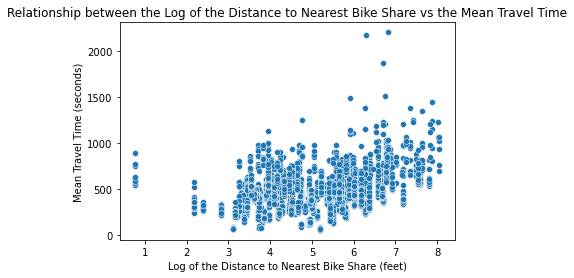

In [150]:
'''
r = np.corrcoef(final_table['log distance to bike(feet)'] , final_table['Mean_Travel_Time_AQ_Seconds'])
print(f"Correlation between log distance to bike station and mean travel time aq is {r[0][1]}")

sns.scatterplot(x='log distance to bike(feet)', y='Mean_Travel_Time_AQ_Seconds', data=final_table)
plt.title("Relationship between the Log of the Distance to Nearest Bike Share vs the Mean Travel Time")
plt.xlabel('Log of the Distance to Nearest Bike Share (feet)')
plt.ylabel('Mean Travel Time (seconds)')
'''

## BASELINE MODEL: SIMPLE LINEAR REGRESSION using log distance to bike station column.


In [151]:
'''
#Randomly shuffle the table and split dataset into training and validation
final_table_baseline=final_table.sample(frac = 1, random_state = 715)
breakPoint = int(0.8*len(final_table))
train, test = final_table_baseline[:breakPoint], final_table_baseline[breakPoint + 1:]
X_train_baseline, y_train_baseline = train[['log distance to bike(feet)']], train['Mean_Travel_Time_AQ_Seconds']
X_val_baseline, y_val_baseline = test[['log distance to bike(feet)']], test['Mean_Travel_Time_AQ_Seconds']
'''

In [152]:
'''
reg = LinearRegression() # Create a new Linear Regression Model
reg.fit(X_train_baseline, y_train_baseline)
'''

LinearRegression()

In [153]:
'''
y_val_pred = reg.predict(X_val_baseline)
validation_error = np.sqrt(mean_squared_error(y_val_baseline, y_val_pred))
score = r2_score(y_val_baseline,  y_val_pred)
print(f"Validation error for baseline model: {validation_error}")
print(f"R^2 score for baseline model: {score}")
'''

Validation error for baseline model: 198.1545550197781
R^2 score for baseline model: 0.15361287674250856


In [154]:
'''
y_train_pred = reg.predict(X_train_baseline)
training_error = np.sqrt(mean_squared_error(y_train_baseline, y_train_pred))
score = r2_score(y_train_baseline, y_train_pred)
print(f"Training error for baseline model: {training_error}")
print(f"R^2 score for baseline model: {score}")
'''

Training error for baseline model: 199.3916911946782
R^2 score for baseline model: 0.15123432952174165


In [155]:
'''
cv = KFold(n_splits = 5, shuffle = True, random_state = 715) #5-fold cross validation!
r_square = cross_val_score(reg, X_train_baseline, y_train_baseline, cv=cv, scoring='r2')
print(f'Model Average R^2 value: {r_square.mean()}')
scores = cross_val_score(reg, X_train_baseline, y_train_baseline, cv=cv, scoring='neg_root_mean_squared_error') 
print(f'Model Average RMSE (CV): {(-1 *scores).mean()} (Seconds)')
'''

Model Average R^2 value: 0.1495104774650315
Model Average RMSE (CV): 199.3105397718739 (Seconds)


## Graphs and Statistics to evaluate the baseline model

Text(0.5, 1.0, 'Plot of predicted mean travel after quarantine(seconds) vs actual mean travel after quarantine(seconds)')

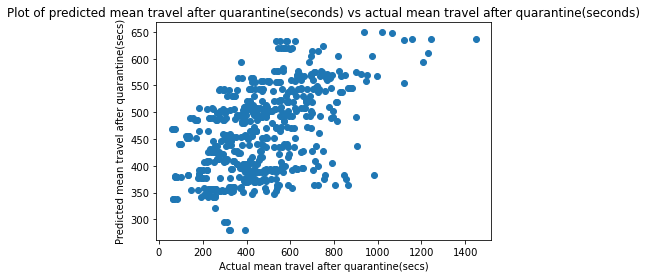

In [69]:
'''
plt.scatter(y_val_baseline, y_val_pred) 
plt.xlabel("Actual mean travel after quarantine(secs)")
plt.ylabel("Predicted mean travel after quarantine(secs)")
plt.title("Plot of predicted mean travel after quarantine(seconds) vs actual mean travel after quarantine(seconds)")
'''

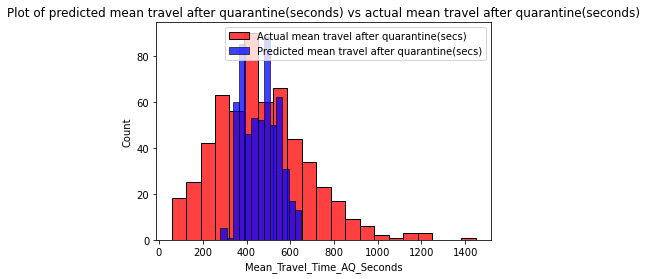

In [70]:
'''
sns.histplot(y_val_baseline,color="red", label='Actual mean travel after quarantine(secs)') ##TOADD
sns.histplot(y_val_pred,color="blue", label='Predicted mean travel after quarantine(secs)')
plt.title("Plot of predicted mean travel after quarantine(seconds) vs actual mean travel after quarantine(seconds)")
plt.legend()
'''

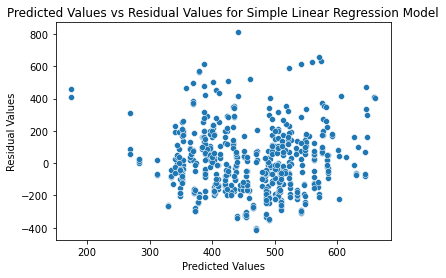

In [158]:
'''
#residual plot
residual = y_val_baseline - y_val_pred
sns.scatterplot(x = y_val_pred, y = residual)
plt.xlabel('Predicted Values')
plt.ylabel('Residual Values')
plt.title('Predicted Values vs Residual Values for Simple Linear Regression Model')
plt.show()
'''

Text(0.5, 1.0, 'Distribution of the R^2 Scores for the Simple Linear Regression')

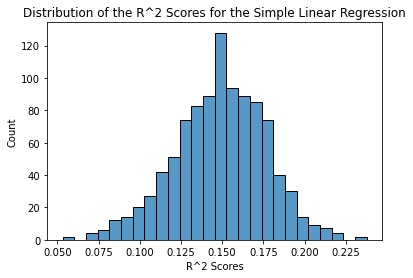

In [159]:
'''
#Hyperparamter is the random state seed
allStates = []
for x in range(1000):
    final_table_new=final_table.sample(frac = 1, random_state=x)
    breakPoint = int(0.8*len(final_table))
    train = final_table_new[:breakPoint]
    test = final_table_new[breakPoint + 1:]
    X_train = train[['log distance to bike(feet)']]
    y_train = train['Mean_Travel_Time_AQ_Seconds']
    X_val=test[['log distance to bike(feet)']]
    y_val=test['Mean_Travel_Time_AQ_Seconds']
    reg =  LinearRegression() # set to trained linear model
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_val)
    score = r2_score(y_val, y_pred)
    allStates.append(score)
sns.histplot(allStates)
plt.xlabel('R^2 Scores')
plt.title('Distribution of the R^2 Scores for the Simple Linear Regression')
'''

In [ ]:
'''
#Plot to explore training and validation error for each of the columns
colsForX= ['log distance to bike(feet)','distance from origin', 'speed_mph_mean', 'duration_sec']
trainingErrordict={}
valErrordict={}
for i in colsForX:
    X_train_baseline, y_train_baseline = train[[i]], train['Mean_Travel_Time_AQ_Seconds']
    X_val_baseline, y_val_baseline = test[[i]], test['Mean_Travel_Time_AQ_Seconds']
    reg = LinearRegression() # Create a new Linear Regression Model
    reg.fit(X_train_baseline, y_train_baseline)
    y_val_pred = reg.predict(X_val_baseline)
    validation_error = np.sqrt(mean_squared_error(y_val_baseline, y_val_pred))
    y_train_pred = reg.predict(X_train_baseline)
    training_error = np.sqrt(mean_squared_error(y_train_baseline, y_train_pred))
    trainingErrordict[i] =  training_error
    valErrordict[i] =validation_error

#Graph the results in a double bar graph!
plt.bar(np.arange(len(trainingErrordict)) - 0.2, list(trainingErrordict.values()),  width = 0.2, color='orange')
plt.bar(np.arange(len(valErrordict)), list(valErrordict.values()), width = 0.2, color='cyan')
plt.xticks(np.arange(len(valErrordict)), ['log dist to bike(ft)','dist from origin', 'speed_mph_mean', 'duration_sec'])
plt.xlabel("Column Name"), plt.ylabel("Error") , plt.title("Comparing training and validation error for different variables used in linear regression")
plt.legend(["Training Error", "Validation Error"])
plt.show()
'''

## Question 5b

Improve on your baseline model. Specify the model you designed and its input features. Justify why you chose these features and their relevance to your model's predictions.

**Example**

Here are potential questions to consider for this part: How does the other variant of your travel times dataset, aggregated across time but reported for all routes, useful?  What additional data from the Uber Movement website can you export to better your model?

## Improved Model 1 -- Simple Linear Regression with removed outliers

In [223]:
'''
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    df = data.copy()    
    return  df.loc[(df[variable] > lower) & (df[variable] < upper), :]

def findOutlierRange(col): ## using interquartile range
    a= col.quantile(0.25).values[0]
    b =col.quantile(0.75).values[0]
    return a-1.5*(b-a), b+1.5*(b-a)

x, y = findOutlierRange(final_table[['Mean_Travel_Time_AQ_Seconds']])
final_data_no_outliers = remove_outliers(final_table, 'Mean_Travel_Time_AQ_Seconds', 0, int(y))
'''

In [224]:
'''
final_table_no_outliers = final_data_no_outliers.sample(frac = 1, random_state = 715)
final_table_new = final_data_no_outliers.sample(frac = 1, random_state = 715)
breakPoint = int(0.8*len(final_table_new))
train, test = final_table_new[:breakPoint], final_table_new[breakPoint + 1:]
X_train_no_outliers , y_train_no_outliers  = train[['log distance to bike(feet)']], train['Mean_Travel_Time_AQ_Seconds']
X_val_no_outliers , y_val_no_outliers  = test[['log distance to bike(feet)']], test['Mean_Travel_Time_AQ_Seconds']
reg_no_outliers  = LinearRegression() #Create simple linear regression model
reg_no_outliers .fit(X_train_no_outliers , y_train_no_outliers )
y_pred_val_no_outliers  = reg_no_outliers .predict(X_val_no_outliers )
validation_r2_score = r2_score(y_val_no_outliers , y_pred_val_no_outliers )
validation_error = np.sqrt(mean_squared_error(y_val_no_outliers , y_pred_val_no_outliers ))
print(f"Validation error for improved model 1 : {validation_error}")
print(f"R^2 score for improved model 1: {validation_r2_score}")
'''

Validation error for improved model 1 : 173.38997953887386
R^2 score for improved model 1: 0.18199153303992033


In [225]:
'''
cv = KFold(n_splits = 5, shuffle = True, random_state = 715) #5-fold cross validation!
r_square = cross_val_score(reg_no_outliers , X_train_no_outliers , y_train_no_outliers , cv=cv, scoring='r2')
print(f'Model Average R^2 value for improved model 1 : {r_square.mean()}')
scores = cross_val_score(reg_no_outliers , X_train_no_outliers , y_train_no_outliers , cv=cv, scoring='neg_root_mean_squared_error') 
print(f'Model Average RMSE (CV) for improved model 1 : {(-1 *scores).mean()} (Seconds)')
'''

Model Average R^2 value for improved model 1 : 0.10867483481571856
Model Average RMSE (CV) for improved model 1 : 180.69682064195263 (Seconds)


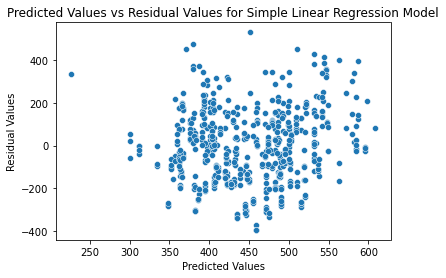

In [226]:
'''
#residual plot
residual_no_outliers  = y_val_no_outliers  - y_pred_val_no_outliers 
sns.scatterplot(x = y_pred_val_no_outliers  , y = residual_no_outliers )
plt.xlabel('Predicted Values')
plt.ylabel('Residual Values')
plt.title('Predicted Values vs Residual Values for Simple Linear Regression Model')
plt.show()
'''

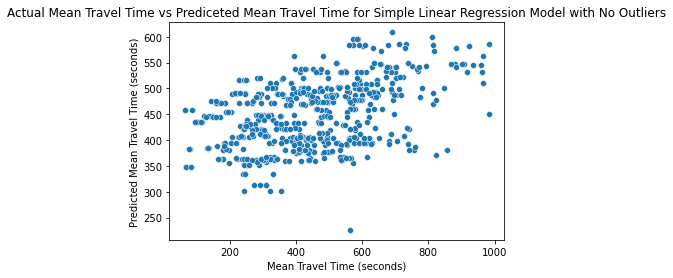

In [227]:
'''
sns.scatterplot(x = y_val_no_outliers, y = y_pred_val_no_outliers )
plt.title('Actual Mean Travel Time vs Prediceted Mean Travel Time for Simple Linear Regression Model with No Outliers')
plt.xlabel('Mean Travel Time (seconds)')
plt.ylabel('Predicted Mean Travel Time (seconds)')
plt.show()
'''

## Improved Model 2 -- Multiple Linear Regression with removed outliers

<AxesSubplot:xlabel='log duration_sec', ylabel='Mean_Travel_Time_AQ_Seconds'>

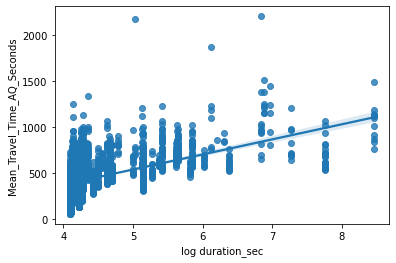

In [228]:
'''
sns.regplot(x = final_table['log duration_sec'], y = final_table['Mean_Travel_Time_AQ_Seconds'])
'''

<AxesSubplot:xlabel='distance from origin', ylabel='Mean_Travel_Time_AQ_Seconds'>

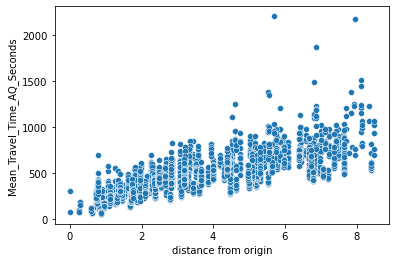

In [229]:
'''
sns.scatterplot(x = final_table['distance from origin'], y = final_table['Mean_Travel_Time_AQ_Seconds'])
'''

<AxesSubplot:xlabel='log speed_mph_mean', ylabel='Mean_Travel_Time_AQ_Seconds'>

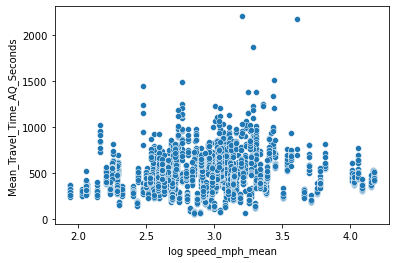

In [230]:
'''
sns.scatterplot(x = final_table['log speed_mph_mean'], y = final_table['Mean_Travel_Time_AQ_Seconds'])
'''

<AxesSubplot:xlabel='speed_mph_mean', ylabel='Mean_Travel_Time_AQ_Seconds'>

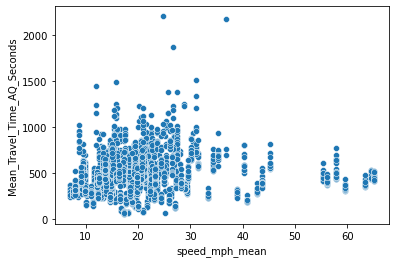

In [231]:
'''
sns.scatterplot(x = final_table['speed_mph_mean'], y = final_table['Mean_Travel_Time_AQ_Seconds'])
'''

After we observed some sort of relationship in the graph above, we decided to use those variables in our multiple linear regression!

In [232]:
'''
final_table_new=final_data_no_outliers.sample(frac = 1, random_state = 715)
breakPoint = int(0.8*len(final_table))
multi_train = final_table_new[:breakPoint]
multi_test = final_table_new[breakPoint + 1:]

multi_X_train, multi_y_train = multi_train[['log distance to bike(feet)','distance from origin', 'speed_mph_mean', 'log duration_sec', 'weekend']], multi_train['Mean_Travel_Time_AQ_Seconds']
multi_X_val, multi_y_val = multi_test[['log distance to bike(feet)', 'distance from origin', 'speed_mph_mean', 'log duration_sec', 'weekend']], multi_test['Mean_Travel_Time_AQ_Seconds']

multi_reg =  LinearRegression() #Create Multiple Linear Regression Model
multi_reg.fit(multi_X_train, multi_y_train)
multi_y_pred = multi_reg.predict(multi_X_val)
validation_r2_score = r2_score(multi_y_val, multi_y_pred)
validation_error = np.sqrt(mean_squared_error(multi_y_val, multi_y_pred))
print(f"Validation error for improved model 2 : {validation_error}")
print(f"R^2 score for no outliers for improved model 2: {validation_r2_score}")
'''

Validation error for improved model 2 : 173.38997953887386
R^2 score for no outliers for improved model 2: 0.6749869977798271


In [233]:
'''
cv = KFold(n_splits = 5, shuffle = True, random_state = 715) #5-fold cross validation!
r_square = cross_val_score(multi_reg, multi_X_train, multi_y_train, cv=cv, scoring='r2')
print(f'Model Average R^2 value for improved model 2 : {r_square.mean()}')
scores = cross_val_score(multi_reg, multi_X_train, multi_y_train, cv=cv, scoring='neg_root_mean_squared_error') 
print(f'Model Average RMSE (CV) for improved model 2 : {(-1 *scores).mean()} (Seconds)')
'''

Model Average R^2 value for improved model 2 : 0.6424309093737153
Model Average RMSE (CV) for improved model 2 : 114.3904805490574 (Seconds)


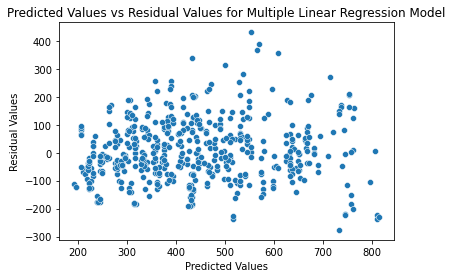

In [234]:
'''
#residual plot
residual_no_outliersMultiple  = multi_y_val  - multi_y_pred
sns.scatterplot(x = multi_y_pred  , y = residual_no_outliersMultiple )
plt.xlabel('Predicted Values')
plt.ylabel('Residual Values')
plt.title('Predicted Values vs Residual Values for Multiple Linear Regression Model')
plt.show()
'''

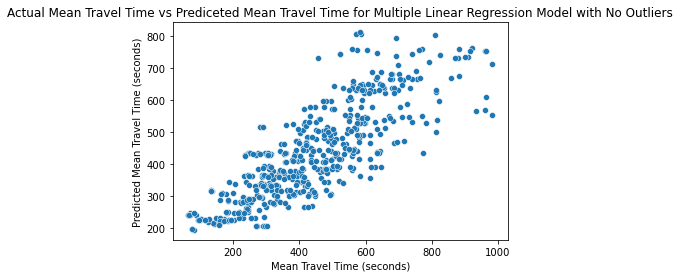

In [235]:
'''
sns.scatterplot(x =  multi_y_val , y = multi_y_pred)
plt.title('Actual Mean Travel Time vs Prediceted Mean Travel Time for Multiple Linear Regression Model with No Outliers')
plt.xlabel('Mean Travel Time (seconds)')
plt.ylabel('Predicted Mean Travel Time (seconds)')
plt.show()
'''

## Question 5c

Explore other modeling aspects and/or temporal information. You are free to relate this to your hypothesis or not. Please expand into multiple parts that logically separate and break down your modeling work!

**Example**

For example, explore change across time, before and after the lockdown: (a) train and evaluate on *pre*-lockdown traffic travel times for that route; and (b) evaluate your model on *post*-lockdown traffic patterns.
How would you correct your model for a more accurate post-lockdown traffic predictor? *The above is just a suggestion. You may pick any topic you find interesting.*

In [ ]:
#train and evaluate pre-lockdown

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [347]:
grader.check_all()

q1a results: All test cases passed!

q1bi results: All test cases passed!

q1bii results: All test cases passed!

q1biii results: All test cases passed!

q1biv results: All test cases passed!

q1bv3 results: All test cases passed!

q1ci results: All test cases passed!

q1cii results: All test cases passed!

q1ciii results: All test cases passed!

q1civ3 results: All test cases passed!

q2ai2 results: All test cases passed!

q2ai3 results: All test cases passed!

q2ai4 results: All test cases passed!

q2aii2 results: All test cases passed!

q2aiii results: All test cases passed!

q2aiv3 results: All test cases passed!

q2av2 results: All test cases passed!

q4ai1 results: All test cases passed!

q4ai2 results: All test cases passed!

q4ai3 results: All test cases passed!

q4aii2 results: All test cases passed!

q4bi1 results: All test cases passed!

q4ci2 results: All test cases passed!

q4ci3 results: All test cases passed!

q4ci4 results:
    q4ci4 - 1 result:
        Trying:
        

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [348]:
# Save your notebook first, then run this cell to export your submission.
grader.export()